# Calculating time scales for *cis/trans* isomerization


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import os

In [2]:
os.makedirs('autocoorel_data', exist_ok=True)

## Load Important Function

In [3]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [4]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Load in the omega angle trajectories by result

In [5]:
# Parameters
residues_to_plot = [0, 1, 2]  # Residues to plot
num_residues = len(residues_to_plot)

save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (742, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")
all_cistrans[0]

First array shape after conversion: (9002, 3)


array([[1, 1, 1],
       [0, 1, 1],
       [0, 1, 1],
       ...,
       [0, 1, 1],
       [0, 0, 1],
       [0, 0, 1]])

#### compile transition probabilities as a function of lag time (in steps)

In [6]:
def compute_transition_matrix(subset, num_states, lagtime, pseudocount=0.25):
    """Compute transition matrix for a given subset of trajectories."""
    
    C = np.zeros((num_states, num_states))  # Initialize count matrix

    for traj in subset:
        for t in range(len(traj) - lagtime):
            from_state = traj[t]
            to_state = traj[t + lagtime]

            # Skip NaN transitions
            if np.isnan(from_state) or np.isnan(to_state):
                continue

            # Convert states to integers for indexing
            from_state = int(from_state)
            to_state = int(to_state)

            # Count transitions
            C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    T = C / row_sums        
    
    return T

In [7]:
def compute_stationary_distribution(T, lagtime):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    t2 - The implied timescale (in units of steps).
    """
    try:
        # Compute the implied timescale
        evals = np.linalg.eigvals(T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        #print('mu2', mu2, 'evals', evals, 'evals_sorted', evals_sorted, 'T', T)
        
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
        #print('evals_sorted', evals_sorted, 'mu2', mu2, 't2', t2)

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        t2 = np.nan
        pi = None

    return pi, t2

In [8]:
def get_transition_matrices(n_trajs, num_states, lagtime, cluster_size=10, pseudocount=0.25, n_jobs=-1):
    """
    Compute transition matrices for subsets of trajectories in parallel.
    """

    num_trajs = n_trajs.shape[0]  # Number of trajectories
    
    # Shuffle indices
    indices = np.arange(num_trajs)
    np.random.shuffle(indices)

    # Split into clusters
    clusters = [indices[i:i + cluster_size] for i in range(0, num_trajs, cluster_size)]

    # Merge last small cluster with the second-last if needed
    if len(clusters) > 1 and len(clusters[-1]) < cluster_size:
        clusters[-2] = np.concatenate([clusters[-2], clusters[-1]])  
        clusters.pop()

    # Parallel computation of transition matrices
    def process_cluster(cluster):
        subset = n_trajs[cluster]
        # Call your existing compute_transition_matrix
        T = compute_transition_matrix(subset, num_states, lagtime, pseudocount)
        return T

    # Use joblib's Parallel for parallelism. 
    # `delayed(process_cluster)(c)` calls `process_cluster(c)` lazily.
    # `n_jobs=-1` uses all available CPUs unless specified otherwise.
    transition_matrices = Parallel(n_jobs=n_jobs)(
        delayed(process_cluster)(cluster) 
        for cluster in tqdm(clusters, desc="Computing transition matrices", unit="cluster")
    )

    return transition_matrices


In [9]:
def process_trajectory(n_trajs, lagtime, num_states, cluster_size):

    # Calculate the transition matrix 
    transition_matrices = get_transition_matrices(n_trajs, num_states, lagtime, cluster_size, pseudocount=0.25, n_jobs=-1)
    transition_matrices = np.array(transition_matrices)
    print('transition_matrices.shape', transition_matrices.shape)
    print(transition_matrices)

    # Calculate the stationary population 
    pi_all = []
    t2_all = []

    
    for T in transition_matrices:
        pi, t2 = compute_stationary_distribution(T, lagtime)
        pi_all.append(pi)
        t2_all.append(t2)

    pi_all = np.array(pi_all)
    t2_all = np.array(t2_all)


    t2_mean = np.exp(np.nanmean([np.log(t2) for t2 in t2_all]))  # Geometric mean
    t2_std = np.exp(np.sqrt(np.nanvar([np.log(t2) for t2 in t2_all])))  # Geometric std dev
    pi_means = np.nanmean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.nanstd(pi_all, axis=0)  # Standard deviation
    
    print('t2_mean, pi_means:', t2_mean, pi_means)
    return pi_means, pi_std, t2_mean, t2_std, transition_matrices

#print(pi_all)

## Let's make an implied timescale plot for each omega angle

In [10]:
## Create a nah filling array where to make sure all the traj are the same length

ntraj = len(all_omega)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

traj


maxlength 37002


array([[[ 1.,  1.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

(37002, 3)


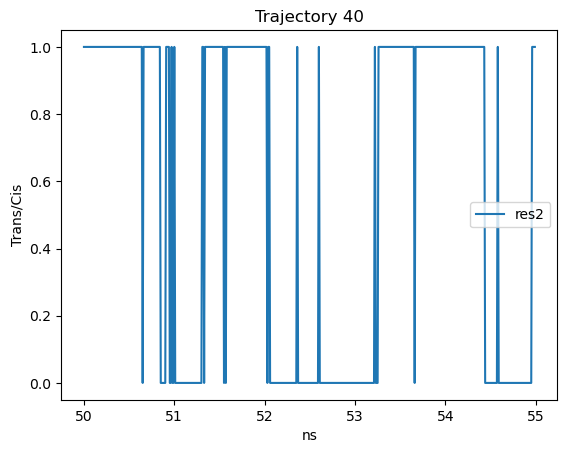

(37002, 3)


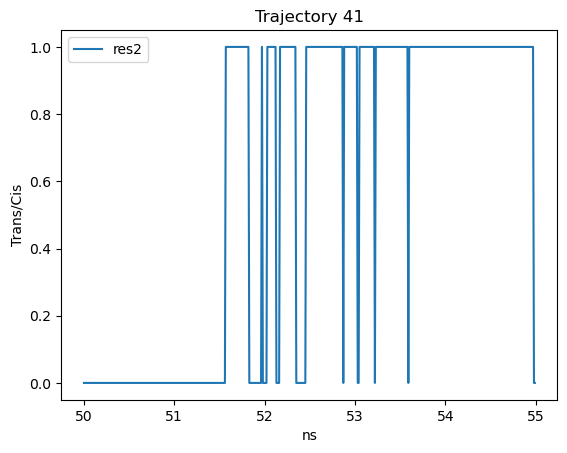

(37002, 3)


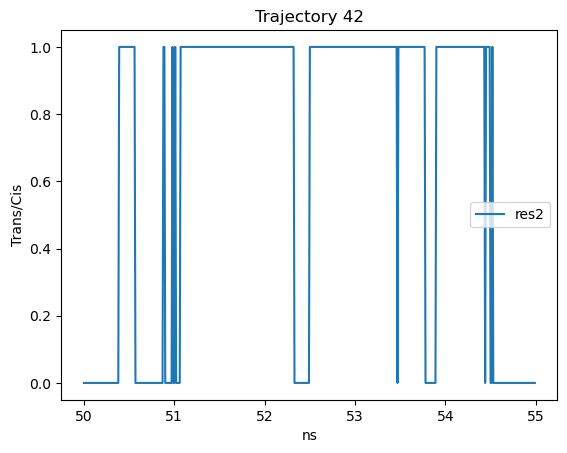

(37002, 3)


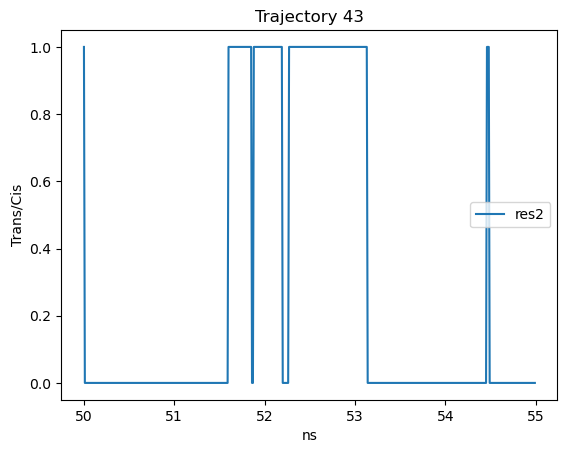

(37002, 3)


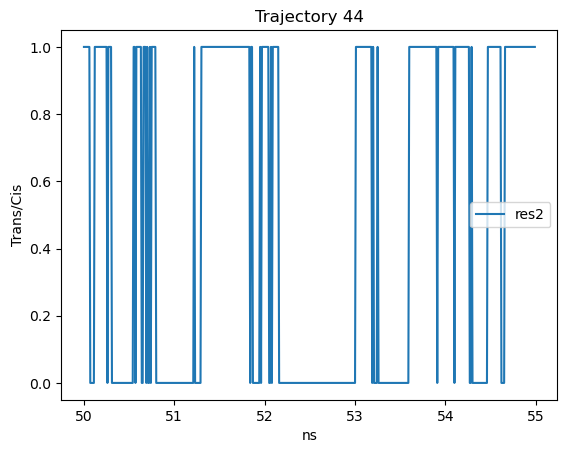

In [11]:
step_to_plot = np.arange(5000, 5500)  # Corrected step range
dt_in_ns = 0.01 # 10 ps to 1 ns

for i in range(40, 45):
    print(traj[i].shape)
    #plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 0], label='res0')  # X component
    #plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 1], label='res1')  # Y component
    plt.plot(step_to_plot * dt_in_ns, traj[i][step_to_plot, 2], label='res2')  # Z component
    
    plt.xlabel("ns")
    plt.ylabel("Trans/Cis")
    plt.legend(loc='best')  # Automatically places the legend in the best position
    plt.title(f"Trajectory {i}")
    plt.show()


### Calculating the implied timescale and stationary population

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

dt_in_ns = 0.01
residues = [0, 1, 2]

n_result = len(all_omega)  # Ensure all_omega is defined
n_trajs = traj  # Ensure traj is defined

num_states = 2
#lagtimes = [5, 10, 25, 50]
lagtimes = [5, 10, 25, 50] + list(range(100, 40000, 500))
cluster_size = 10

# Store results with proper shape: (n_residues, n_lagtimes)
pi_all_means = []
pi_all_stds = []
t2_all_means = []
t2_all_stds = []
transition_matrices_all_res = []

for residue in residues:
    print(f'Processing residue {residue} with lagtimes = {lagtimes}')
    
    pi_means_res = []
    pi_stds_res = []
    t2_means_res = []
    t2_stds_res = []
    transition_matrices_res = []
    
    for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):
        pi_means, pi_std, t2_mean, t2_std, transition_matrices= process_trajectory(n_trajs[:, :, residue], lagtime, num_states, cluster_size)
        
        pi_means_res.append(pi_means)
        pi_stds_res.append(pi_std)
        t2_means_res.append(t2_mean)
        t2_stds_res.append(t2_std)

    # Append per-residue results
    pi_all_means.append(pi_means_res)
    pi_all_stds.append(pi_stds_res)
    t2_all_means.append(t2_means_res)
    t2_all_stds.append(t2_stds_res)
    transition_matrices_all_res.append(transition_matrices)

# Convert to NumPy arrays for easier indexing
pi_all_means = np.array(pi_all_means)  # Shape: (n_residues, n_lagtimes)
pi_all_stds = np.array(pi_all_stds)
t2_all_means = np.array(t2_all_means)
t2_all_stds = np.array(t2_all_stds)
transition_matrices_all_res = np.array(transition_matrices_all_res)

lagtimes_ns = np.array(lagtimes) * dt_in_ns


Processing residue 0 with lagtimes = [5, 10, 25, 50, 100, 600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600, 5100, 5600, 6100, 6600, 7100, 7600, 8100, 8600, 9100, 9600, 10100, 10600, 11100, 11600, 12100, 12600, 13100, 13600, 14100, 14600, 15100, 15600, 16100, 16600, 17100, 17600, 18100, 18600, 19100, 19600, 20100, 20600, 21100, 21600, 22100, 22600, 23100, 23600, 24100, 24600, 25100, 25600, 26100, 26600, 27100, 27600, 28100, 28600, 29100, 29600, 30100, 30600, 31100, 31600, 32100, 32600, 33100, 33600, 34100, 34600, 35100, 35600, 36100, 36600, 37100, 37600, 38100, 38600, 39100, 39600]


Processing Lag Times:   1%|          | 1/84 [00:05<07:30,  5.43s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.67312337 0.32687663]
  [0.13465162 0.86534838]]

 [[0.68344211 0.31655789]
  [0.13516879 0.86483121]]

 [[0.67572596 0.32427404]
  [0.13800327 0.86199673]]

 [[0.67721071 0.32278929]
  [0.13335485 0.86664515]]

 [[0.67177604 0.32822396]
  [0.13743926 0.86256074]]

 [[0.68574182 0.31425818]
  [0.13198164 0.86801836]]

 [[0.68599051 0.31400949]
  [0.13343751 0.86656249]]

 [[0.66864723 0.33135277]
  [0.13492517 0.86507483]]]
t2_mean, pi_means: 8.184834180820078 [0.2950447 0.7049553]


Processing Lag Times:   2%|▏         | 2/84 [00:07<04:26,  3.25s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.5769467  0.4230533 ]
  [0.17792477 0.82207523]]

 [[0.56987062 0.43012938]
  [0.17473199 0.82526801]]

 [[0.56930352 0.43069648]
  [0.18138188 0.81861812]]

 [[0.56266042 0.43733958]
  [0.18179621 0.81820379]]

 [[0.59225418 0.40774582]
  [0.17207834 0.82792166]]

 [[0.56829109 0.43170891]
  [0.17524516 0.82475484]]

 [[0.57013632 0.42986368]
  [0.17926641 0.82073359]]

 [[0.58672881 0.41327119]
  [0.18012671 0.81987329]]]
t2_mean, pi_means: 10.816358220637015 [0.29478259 0.70521741]


Processing Lag Times:   4%|▎         | 3/84 [00:08<03:29,  2.58s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.42517168 0.57482832]
  [0.24737038 0.75262962]]

 [[0.41230257 0.58769743]
  [0.2376916  0.7623084 ]]

 [[0.41345111 0.58654889]
  [0.24339891 0.75660109]]

 [[0.4120394  0.5879606 ]
  [0.23496329 0.76503671]]

 [[0.42258872 0.57741128]
  [0.23594798 0.76405202]]

 [[0.41307798 0.58692202]
  [0.24510744 0.75489256]]

 [[0.43698845 0.56301155]
  [0.24688978 0.75311022]]

 [[0.42291822 0.57708178]
  [0.24819947 0.75180053]]]
t2_mean, pi_means: 14.45216173397917 [0.2947372 0.7052628]


Processing Lag Times:   5%|▍         | 4/84 [00:10<03:03,  2.29s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.31906515 0.68093485]
  [0.27548064 0.72451936]]

 [[0.34585641 0.65414359]
  [0.27996904 0.72003096]]

 [[0.35961075 0.64038925]
  [0.28074514 0.71925486]]

 [[0.3278742  0.6721258 ]
  [0.2767471  0.7232529 ]]

 [[0.32991222 0.67008778]
  [0.28096349 0.71903651]]

 [[0.33249367 0.66750633]
  [0.27398859 0.72601141]]

 [[0.33190171 0.66809829]
  [0.27194745 0.72805255]]

 [[0.34702308 0.65297692]
  [0.27878702 0.72121298]]]
t2_mean, pi_means: 17.641154547304545 [0.29489069 0.70510931]


Computing transition matrices: 100%|██████████| 8/8 [00:00<00:00, 1290.70cluster/s]
/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_33063/606344109.py:18: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
Processing Lag Times:   6%|▌         | 5/84 [00:12<02:48,  2.14s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29681684 0.70318316]
  [0.29756894 0.70243106]]

 [[0.31424165 0.68575835]
  [0.28937951 0.71062049]]

 [[0.30938498 0.69061502]
  [0.28488577 0.71511423]]

 [[0.30264686 0.69735314]
  [0.29076211 0.70923789]]

 [[0.31229431 0.68770569]
  [0.29617405 0.70382595]]

 [[0.2959229  0.7040771 ]
  [0.28209263 0.71790737]]

 [[0.32117875 0.67882125]
  [0.30029237 0.69970763]]

 [[0.29696243 0.70303757]
  [0.28469365 0.71530635]]]
t2_mean, pi_means: 24.613501043144616 [0.29530077 0.70469923]


Processing Lag Times:   7%|▋         | 6/84 [00:14<02:43,  2.10s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29889394 0.70110606]
  [0.28465926 0.71534074]]

 [[0.31277131 0.68722869]
  [0.29956486 0.70043514]]

 [[0.28995588 0.71004412]
  [0.28941681 0.71058319]]

 [[0.30099135 0.69900865]
  [0.30200797 0.69799203]]

 [[0.2851242  0.7148758 ]
  [0.28358027 0.71641973]]

 [[0.28491623 0.71508377]
  [0.3006147  0.6993853 ]]

 [[0.31021319 0.68978681]
  [0.30018915 0.69981085]]

 [[0.29492716 0.70507284]
  [0.2942934  0.7057066 ]]]
t2_mean, pi_means: 107.41181775792641 [0.29516424 0.70483576]


Processing Lag Times:   8%|▊         | 7/84 [00:16<02:38,  2.06s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29996752 0.70003248]
  [0.30126709 0.69873291]]

 [[0.28882382 0.71117618]
  [0.28517246 0.71482754]]

 [[0.29096808 0.70903192]
  [0.30018923 0.69981077]]

 [[0.29784567 0.70215433]
  [0.28756963 0.71243037]]

 [[0.30596514 0.69403486]
  [0.30298661 0.69701339]]

 [[0.29658892 0.70341108]
  [0.29248373 0.70751627]]

 [[0.28868107 0.71131893]
  [0.29266704 0.70733296]]

 [[0.29200887 0.70799113]
  [0.29624528 0.70375472]]]
t2_mean, pi_means: 205.47976774366268 [0.29489716 0.70510284]


Processing Lag Times:  10%|▉         | 8/84 [00:18<02:32,  2.01s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29778252 0.70221748]
  [0.30331797 0.69668203]]

 [[0.31308754 0.68691246]
  [0.29999063 0.70000937]]

 [[0.29037561 0.70962439]
  [0.29128152 0.70871848]]

 [[0.29811632 0.70188368]
  [0.29203768 0.70796232]]

 [[0.28060856 0.71939144]
  [0.28685184 0.71314816]]

 [[0.29350898 0.70649102]
  [0.29423816 0.70576184]]

 [[0.29558986 0.70441014]
  [0.30221876 0.69778124]]

 [[0.2867285  0.7132715 ]
  [0.29945863 0.70054137]]]
t2_mean, pi_means: 340.1690252038312 [0.29568504 0.70431496]


Processing Lag Times:  11%|█         | 9/84 [00:20<02:26,  1.96s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29813582 0.70186418]
  [0.31237899 0.68762101]]

 [[0.28399803 0.71600197]
  [0.28983035 0.71016965]]

 [[0.29768433 0.70231567]
  [0.29822565 0.70177435]]

 [[0.293571   0.706429  ]
  [0.29042177 0.70957823]]

 [[0.3010981  0.6989019 ]
  [0.29192515 0.70807485]]

 [[0.29535397 0.70464603]
  [0.28707017 0.71292983]]

 [[0.29473549 0.70526451]
  [0.30189558 0.69810442]]

 [[0.29968236 0.70031764]
  [0.29247078 0.70752922]]]
t2_mean, pi_means: 417.6910799079344 [0.29549825 0.70450175]


Processing Lag Times:  12%|█▏        | 10/84 [00:22<02:20,  1.90s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.298032   0.701968  ]
  [0.29164347 0.70835653]]

 [[0.28489579 0.71510421]
  [0.29030116 0.70969884]]

 [[0.29846034 0.70153966]
  [0.29652597 0.70347403]]

 [[0.28677703 0.71322297]
  [0.29729722 0.70270278]]

 [[0.30159787 0.69840213]
  [0.29887899 0.70112101]]

 [[0.28950174 0.71049826]
  [0.28864007 0.71135993]]

 [[0.29249546 0.70750454]
  [0.30051639 0.69948361]]

 [[0.30209957 0.69790043]
  [0.2969774  0.7030226 ]]]
t2_mean, pi_means: 443.2814001907144 [0.29484703 0.70515297]


Processing Lag Times:  13%|█▎        | 11/84 [00:24<02:28,  2.03s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30696033 0.69303967]
  [0.30888135 0.69111865]]

 [[0.29566073 0.70433927]
  [0.29378263 0.70621737]]

 [[0.30254888 0.69745112]
  [0.29259137 0.70740863]]

 [[0.29166179 0.70833821]
  [0.28737786 0.71262214]]

 [[0.30310383 0.69689617]
  [0.28358178 0.71641822]]

 [[0.30014516 0.69985484]
  [0.30782448 0.69217552]]

 [[0.297588   0.702412  ]
  [0.28838955 0.71161045]]

 [[0.30154784 0.69845216]
  [0.29557955 0.70442045]]]
t2_mean, pi_means: 624.8364385969594 [0.2962376 0.7037624]


Processing Lag Times:  14%|█▍        | 12/84 [00:26<02:26,  2.04s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29103806 0.70896194]
  [0.28887305 0.71112695]]

 [[0.30022667 0.69977333]
  [0.29806308 0.70193692]]

 [[0.29894174 0.70105826]
  [0.28645309 0.71354691]]

 [[0.30227885 0.69772115]
  [0.30328822 0.69671178]]

 [[0.27534854 0.72465146]
  [0.29177475 0.70822525]]

 [[0.29808423 0.70191577]
  [0.29941124 0.70058876]]

 [[0.29410937 0.70589063]
  [0.28623777 0.71376223]]

 [[0.31687976 0.68312024]
  [0.30109837 0.69890163]]]
t2_mean, pi_means: 711.4891642748324 [0.29522204 0.70477796]


Processing Lag Times:  15%|█▌        | 13/84 [00:28<02:18,  1.95s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28971968 0.71028032]
  [0.30088667 0.69911333]]

 [[0.29085185 0.70914815]
  [0.2982901  0.7017099 ]]

 [[0.30639107 0.69360893]
  [0.30054288 0.69945712]]

 [[0.28684219 0.71315781]
  [0.29067795 0.70932205]]

 [[0.29627219 0.70372781]
  [0.30354332 0.69645668]]

 [[0.29538592 0.70461408]
  [0.29475229 0.70524771]]

 [[0.29200957 0.70799043]
  [0.29429942 0.70570058]]

 [[0.29061468 0.70938532]
  [0.29815904 0.70184096]]]
t2_mean, pi_means: 666.3084592084574 [0.2964218 0.7035782]


Processing Lag Times:  17%|█▋        | 14/84 [00:30<02:12,  1.89s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.32206567 0.67793433]
  [0.29892741 0.70107259]]

 [[0.31049716 0.68950284]
  [0.29994163 0.70005837]]

 [[0.27458433 0.72541567]
  [0.28492089 0.71507911]]

 [[0.29588705 0.70411295]
  [0.28941401 0.71058599]]

 [[0.29668575 0.70331425]
  [0.30249623 0.69750377]]

 [[0.29298929 0.70701071]
  [0.29308852 0.70691148]]

 [[0.29152529 0.70847471]
  [0.29504775 0.70495225]]

 [[0.30788627 0.69211373]
  [0.30060466 0.69939534]]]
t2_mean, pi_means: 1012.9699571860276 [0.29663559 0.70336441]


Processing Lag Times:  18%|█▊        | 15/84 [00:32<02:14,  1.95s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29889091 0.70110909]
  [0.30105269 0.69894731]]

 [[0.28985069 0.71014931]
  [0.29621241 0.70378759]]

 [[0.29328751 0.70671249]
  [0.29372939 0.70627061]]

 [[0.30200847 0.69799153]
  [0.29584993 0.70415007]]

 [[0.31382239 0.68617761]
  [0.30136832 0.69863168]]

 [[0.29723304 0.70276696]
  [0.29467531 0.70532469]]

 [[0.29687269 0.70312731]
  [0.29990254 0.70009746]]

 [[0.29408133 0.70591867]
  [0.29249994 0.70750006]]]
t2_mean, pi_means: 941.9615396909015 [0.29732322 0.70267678]


Processing Lag Times:  19%|█▉        | 16/84 [00:33<02:04,  1.83s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29380525 0.70619475]
  [0.29324594 0.70675406]]

 [[0.28009978 0.71990022]
  [0.28814551 0.71185449]]

 [[0.28506039 0.71493961]
  [0.28611592 0.71388408]]

 [[0.29020531 0.70979469]
  [0.29439717 0.70560283]]

 [[0.27783439 0.72216561]
  [0.28901279 0.71098721]]

 [[0.30336888 0.69663112]
  [0.30294519 0.69705481]]

 [[0.30109379 0.69890621]
  [0.30914371 0.69085629]]

 [[0.30798522 0.69201478]
  [0.31108811 0.68891189]]]
t2_mean, pi_means: 734.2927203651075 [0.29549131 0.70450869]


Processing Lag Times:  20%|██        | 17/84 [00:35<01:59,  1.79s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30698538 0.69301462]
  [0.30290741 0.69709259]]

 [[0.27475949 0.72524051]
  [0.29191423 0.70808577]]

 [[0.31747306 0.68252694]
  [0.29667422 0.70332578]]

 [[0.28210701 0.71789299]
  [0.29441349 0.70558651]]

 [[0.28347479 0.71652521]
  [0.29416916 0.70583084]]

 [[0.31818693 0.68181307]
  [0.3018201  0.6981799 ]]

 [[0.31092843 0.68907157]
  [0.3022901  0.6977099 ]]

 [[0.29272217 0.70727783]
  [0.28420637 0.71579363]]]
t2_mean, pi_means: 1335.9833218736699 [0.29680237 0.70319763]


Processing Lag Times:  21%|██▏       | 18/84 [00:37<01:57,  1.78s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30786542 0.69213458]
  [0.3036595  0.6963405 ]]

 [[0.30504012 0.69495988]
  [0.31069547 0.68930453]]

 [[0.2880914  0.7119086 ]
  [0.29389286 0.70610714]]

 [[0.29354527 0.70645473]
  [0.29203038 0.70796962]]

 [[0.28952563 0.71047437]
  [0.29487222 0.70512778]]

 [[0.28153522 0.71846478]
  [0.30263905 0.69736095]]

 [[0.29648199 0.70351801]
  [0.29141073 0.70858927]]

 [[0.29878564 0.70121436]
  [0.29362967 0.70637033]]]
t2_mean, pi_means: 1176.9913185327314 [0.29703716 0.70296284]


Processing Lag Times:  23%|██▎       | 19/84 [00:38<01:52,  1.74s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29748038 0.70251962]
  [0.30523647 0.69476353]]

 [[0.29066861 0.70933139]
  [0.29485135 0.70514865]]

 [[0.28738356 0.71261644]
  [0.29234046 0.70765954]]

 [[0.28418886 0.71581114]
  [0.29238613 0.70761387]]

 [[0.30105203 0.69894797]
  [0.29692095 0.70307905]]

 [[0.29135691 0.70864309]
  [0.30526959 0.69473041]]

 [[0.30744438 0.69255562]
  [0.29946852 0.70053148]]

 [[0.30644777 0.69355223]
  [0.28834165 0.71165835]]]
t2_mean, pi_means: 1498.4078167962307 [0.29652326 0.70347674]


Processing Lag Times:  24%|██▍       | 20/84 [00:40<01:48,  1.70s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28970234 0.71029766]
  [0.29165284 0.70834716]]

 [[0.30402236 0.69597764]
  [0.30160208 0.69839792]]

 [[0.28606492 0.71393508]
  [0.28579037 0.71420963]]

 [[0.3077946  0.6922054 ]
  [0.30700058 0.69299942]]

 [[0.29373146 0.70626854]
  [0.30217055 0.69782945]]

 [[0.27134827 0.72865173]
  [0.27232022 0.72767978]]

 [[0.30244845 0.69755155]
  [0.29945836 0.70054164]]

 [[0.29706924 0.70293076]
  [0.29706069 0.70293931]]]
t2_mean, pi_means: 1011.7283944969776 [0.2944562 0.7055438]


Processing Lag Times:  25%|██▌       | 21/84 [00:41<01:44,  1.66s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28208127 0.71791873]
  [0.28738059 0.71261941]]

 [[0.29371728 0.70628272]
  [0.28399639 0.71600361]]

 [[0.30080048 0.69919952]
  [0.29923822 0.70076178]]

 [[0.28450456 0.71549544]
  [0.27830012 0.72169988]]

 [[0.30610493 0.69389507]
  [0.29579334 0.70420666]]

 [[0.33369527 0.66630473]
  [0.30475939 0.69524061]]

 [[0.28442042 0.71557958]
  [0.29354744 0.70645256]]

 [[0.30500118 0.69499882]
  [0.2967601  0.7032399 ]]]
t2_mean, pi_means: 1696.8069931078626 [0.29440354 0.70559646]


Processing Lag Times:  26%|██▌       | 22/84 [00:43<01:40,  1.62s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.31841362 0.68158638]
  [0.29425517 0.70574483]]

 [[0.29984217 0.70015783]
  [0.29726555 0.70273445]]

 [[0.2959521  0.7040479 ]
  [0.29137819 0.70862181]]

 [[0.31589474 0.68410526]
  [0.31174531 0.68825469]]

 [[0.29737509 0.70262491]
  [0.29237349 0.70762651]]

 [[0.27708388 0.72291612]
  [0.29504682 0.70495318]]

 [[0.29311851 0.70688149]
  [0.29185049 0.70814951]]

 [[0.29222026 0.70777974]
  [0.29596927 0.70403073]]]
t2_mean, pi_means: 1610.6142452591187 [0.29701289 0.70298711]


Processing Lag Times:  27%|██▋       | 23/84 [00:44<01:36,  1.57s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29923567 0.70076433]
  [0.31298477 0.68701523]]

 [[0.31436136 0.68563864]
  [0.29755518 0.70244482]]

 [[0.30600727 0.69399273]
  [0.28783353 0.71216647]]

 [[0.29816114 0.70183886]
  [0.30232723 0.69767277]]

 [[0.29541302 0.70458698]
  [0.31125655 0.68874345]]

 [[0.29184113 0.70815887]
  [0.29858991 0.70141009]]

 [[0.30109467 0.69890533]
  [0.28131485 0.71868515]]

 [[0.26749683 0.73250317]
  [0.28672562 0.71327438]]]
t2_mean, pi_means: 2272.11809217266 [0.29711421 0.70288579]


Processing Lag Times:  29%|██▊       | 24/84 [00:46<01:33,  1.55s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30027125 0.69972875]
  [0.3025402  0.6974598 ]]

 [[0.30685555 0.69314445]
  [0.31219915 0.68780085]]

 [[0.29299819 0.70700181]
  [0.29588509 0.70411491]]

 [[0.3021469  0.6978531 ]
  [0.30484174 0.69515826]]

 [[0.31189189 0.68810811]
  [0.28694008 0.71305992]]

 [[0.29435946 0.70564054]
  [0.28360131 0.71639869]]

 [[0.30605723 0.69394277]
  [0.29329002 0.70670998]]

 [[0.31581819 0.68418181]
  [0.2972114  0.7027886 ]]]
t2_mean, pi_means: 2325.0735837970146 [0.29904359 0.70095641]


Processing Lag Times:  30%|██▉       | 25/84 [00:47<01:28,  1.50s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28014269 0.71985731]
  [0.28484899 0.71515101]]

 [[0.2951361  0.7048639 ]
  [0.29461984 0.70538016]]

 [[0.2936816  0.7063184 ]
  [0.31150349 0.68849651]]

 [[0.30609215 0.69390785]
  [0.30604633 0.69395367]]

 [[0.31108712 0.68891288]
  [0.30509537 0.69490463]]

 [[0.29928014 0.70071986]
  [0.29134348 0.70865652]]

 [[0.28917921 0.71082079]
  [0.28573856 0.71426144]]

 [[0.29912369 0.70087631]
  [0.30235933 0.69764067]]]
t2_mean, pi_means: 1581.7332219079933 [0.29738927 0.70261073]


Processing Lag Times:  31%|███       | 26/84 [00:49<01:24,  1.45s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.27783442 0.72216558]
  [0.29251642 0.70748358]]

 [[0.30272372 0.69727628]
  [0.31116237 0.68883763]]

 [[0.30313712 0.69686288]
  [0.30078014 0.69921986]]

 [[0.30965917 0.69034083]
  [0.28510132 0.71489868]]

 [[0.28169087 0.71830913]
  [0.30102837 0.69897163]]

 [[0.30751024 0.69248976]
  [0.31061253 0.68938747]]

 [[0.31044098 0.68955902]
  [0.313721   0.686279  ]]

 [[0.29371707 0.70628293]
  [0.29182982 0.70817018]]]
t2_mean, pi_means: 2038.1288103711454 [0.30008234 0.69991766]


Processing Lag Times:  32%|███▏      | 27/84 [00:50<01:18,  1.38s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.31284574 0.68715426]
  [0.31106929 0.68893071]]

 [[0.3117386  0.6882614 ]
  [0.30567618 0.69432382]]

 [[0.28846505 0.71153495]
  [0.29541186 0.70458814]]

 [[0.30778406 0.69221594]
  [0.30683364 0.69316636]]

 [[0.28481123 0.71518877]
  [0.29663632 0.70336368]]

 [[0.30244805 0.69755195]
  [0.28949258 0.71050742]]

 [[0.29213268 0.70786732]
  [0.3036075  0.6963925 ]]

 [[0.29660675 0.70339325]
  [0.28675088 0.71324912]]]
t2_mean, pi_means: 2062.24054090752 [0.29948664 0.70051336]


Processing Lag Times:  33%|███▎      | 28/84 [00:51<01:16,  1.36s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.2895925  0.7104075 ]
  [0.29407671 0.70592329]]

 [[0.31203865 0.68796135]
  [0.31708644 0.68291356]]

 [[0.31734595 0.68265405]
  [0.28870804 0.71129196]]

 [[0.28429504 0.71570496]
  [0.30093111 0.69906889]]

 [[0.29612723 0.70387277]
  [0.28871828 0.71128172]]

 [[0.29318193 0.70681807]
  [0.29910805 0.70089195]]

 [[0.31697537 0.68302463]
  [0.31664645 0.68335355]]

 [[0.2989881  0.7010119 ]
  [0.28494546 0.71505454]]]
t2_mean, pi_means: 2347.531530179128 [0.29943226 0.70056774]


Processing Lag Times:  35%|███▍      | 29/84 [00:52<01:12,  1.33s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30682284 0.69317716]
  [0.29116079 0.70883921]]

 [[0.27855797 0.72144203]
  [0.31269006 0.68730994]]

 [[0.29053452 0.70946548]
  [0.28514234 0.71485766]]

 [[0.28368669 0.71631331]
  [0.30780575 0.69219425]]

 [[0.31697455 0.68302545]
  [0.29756194 0.70243806]]

 [[0.29143532 0.70856468]
  [0.2901941  0.7098059 ]]

 [[0.3034719  0.6965281 ]
  [0.30583137 0.69416863]]

 [[0.25823182 0.74176818]
  [0.30623994 0.69376006]]]
t2_mean, pi_means: 2473.540644114085 [0.29709229 0.70290771]


Processing Lag Times:  36%|███▌      | 30/84 [00:54<01:10,  1.30s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.33747023 0.66252977]
  [0.31405309 0.68594691]]

 [[0.3216875  0.6783125 ]
  [0.30589815 0.69410185]]

 [[0.29940852 0.70059148]
  [0.28896744 0.71103256]]

 [[0.29350073 0.70649927]
  [0.2865685  0.7134315 ]]

 [[0.26640728 0.73359272]
  [0.28592208 0.71407792]]

 [[0.26796574 0.73203426]
  [0.30811678 0.69188322]]

 [[0.29093082 0.70906918]
  [0.31058669 0.68941331]]

 [[0.28304917 0.71695083]
  [0.29423001 0.70576999]]]
t2_mean, pi_means: 2906.401054240147 [0.29815288 0.70184712]


Processing Lag Times:  37%|███▋      | 31/84 [00:55<01:08,  1.30s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29596198 0.70403802]
  [0.30307668 0.69692332]]

 [[0.27485707 0.72514293]
  [0.29578933 0.70421067]]

 [[0.29757189 0.70242811]
  [0.29159179 0.70840821]]

 [[0.28059501 0.71940499]
  [0.29272995 0.70727005]]

 [[0.30450728 0.69549272]
  [0.32533468 0.67466532]]

 [[0.29958305 0.70041695]
  [0.31355677 0.68644323]]

 [[0.30194137 0.69805863]
  [0.31214236 0.68785764]]

 [[0.27746222 0.72253778]
  [0.28872007 0.71127993]]]
t2_mean, pi_means: 2558.934683004319 [0.29945694 0.70054306]


Processing Lag Times:  38%|███▊      | 32/84 [00:56<01:05,  1.26s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.32233414 0.67766586]
  [0.29127605 0.70872395]]

 [[0.28849274 0.71150726]
  [0.29635715 0.70364285]]

 [[0.30737294 0.69262706]
  [0.3045424  0.6954576 ]]

 [[0.31798184 0.68201816]
  [0.3031479  0.6968521 ]]

 [[0.29541774 0.70458226]
  [0.29101488 0.70898512]]

 [[0.27452747 0.72547253]
  [0.27883247 0.72116753]]

 [[0.29634239 0.70365761]
  [0.3136986  0.6863014 ]]

 [[0.29038632 0.70961368]
  [0.29831168 0.70168832]]]
t2_mean, pi_means: 2928.0989791354127 [0.29775356 0.70224644]


Processing Lag Times:  39%|███▉      | 33/84 [00:57<01:03,  1.24s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.303119   0.696881  ]
  [0.28954925 0.71045075]]

 [[0.29555621 0.70444379]
  [0.30516588 0.69483412]]

 [[0.30006773 0.69993227]
  [0.29480443 0.70519557]]

 [[0.27372693 0.72627307]
  [0.30089829 0.69910171]]

 [[0.3043156  0.6956844 ]
  [0.31048235 0.68951765]]

 [[0.29169453 0.70830547]
  [0.30565583 0.69434417]]

 [[0.3056853  0.6943147 ]
  [0.290447   0.709553  ]]

 [[0.29570919 0.70429081]
  [0.30106419 0.69893581]]]
t2_mean, pi_means: 3096.708734489232 [0.29869067 0.70130933]


Computing transition matrices: 100%|██████████| 8/8 [00:00<00:00, 2346.14cluster/s]
/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_33063/1634129454.py:23: RuntimeWarning: Mean of empty slice
  t2_mean = np.exp(np.nanmean([np.log(t2) for t2 in t2_all]))  # Geometric mean
/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_33063/1634129454.py:24: RuntimeWarning: Degrees of freedom <= 0 for slice.
  t2_std = np.exp(np.sqrt(np.nanvar([np.log(t2) for t2 in t2_all])))  # Geometric std dev
Processing Lag Times:  40%|████      | 34/84 [00:59<01:01,  1.22s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28096419 0.71903581]
  [0.29547292 0.70452708]]

 [[0.30126799 0.69873201]
  [0.30371132 0.69628868]]

 [[0.3093856  0.6906144 ]
  [0.31862401 0.68137599]]

 [[0.30023856 0.69976144]
  [0.31201227 0.68798773]]

 [[0.26294996 0.73705004]
  [0.28055703 0.71944297]]

 [[0.28023606 0.71976394]
  [0.29886876 0.70113124]]

 [[0.30985159 0.69014841]
  [0.32039211 0.67960789]]

 [[0.29676893 0.70323107]
  [0.2999322  0.7000678 ]]]
t2_mean, pi_means: nan [0.30043106 0.69956894]


Processing Lag Times:  42%|████▏     | 35/84 [01:00<00:59,  1.20s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28052814 0.71947186]
  [0.28187756 0.71812244]]

 [[0.29193668 0.70806332]
  [0.28678634 0.71321366]]

 [[0.280256   0.719744  ]
  [0.31277976 0.68722024]]

 [[0.32103225 0.67896775]
  [0.33142231 0.66857769]]

 [[0.29483669 0.70516331]
  [0.28044632 0.71955368]]

 [[0.32121972 0.67878028]
  [0.30870352 0.69129648]]

 [[0.29237857 0.70762143]
  [0.2984112  0.7015888 ]]

 [[0.31136962 0.68863038]
  [0.29250673 0.70749327]]]
t2_mean, pi_means: 3400.7879154619154 [0.29907747 0.70092253]


Processing Lag Times:  43%|████▎     | 36/84 [01:01<00:57,  1.20s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28322711 0.71677289]
  [0.30072265 0.69927735]]

 [[0.29910895 0.70089105]
  [0.31423683 0.68576317]]

 [[0.2736511  0.7263489 ]
  [0.28290132 0.71709868]]

 [[0.31313809 0.68686191]
  [0.30963255 0.69036745]]

 [[0.30029439 0.69970561]
  [0.30445243 0.69554757]]

 [[0.30809031 0.69190969]
  [0.32015041 0.67984959]]

 [[0.27423639 0.72576361]
  [0.29871812 0.70128188]]

 [[0.33099765 0.66900235]
  [0.29408414 0.70591586]]]
t2_mean, pi_means: 3612.155538507887 [0.30157484 0.69842516]


Processing Lag Times:  44%|████▍     | 37/84 [01:02<00:55,  1.18s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30241046 0.69758954]
  [0.30185321 0.69814679]]

 [[0.27792442 0.72207558]
  [0.33528736 0.66471264]]

 [[0.32253708 0.67746292]
  [0.2975834  0.7024166 ]]

 [[0.3432304  0.6567696 ]
  [0.32761201 0.67238799]]

 [[0.29183369 0.70816631]
  [0.28533698 0.71466302]]

 [[0.29142376 0.70857624]
  [0.30242318 0.69757682]]

 [[0.33137951 0.66862049]
  [0.3022219  0.6977781 ]]

 [[0.28506723 0.71493277]
  [0.28828222 0.71171778]]]
t2_mean, pi_means: 3504.0471781855094 [0.30526515 0.69473485]


Processing Lag Times:  45%|████▌     | 38/84 [01:03<00:52,  1.15s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29618145 0.70381855]
  [0.31132179 0.68867821]]

 [[0.30970767 0.69029233]
  [0.30908338 0.69091662]]

 [[0.28656524 0.71343476]
  [0.31119758 0.68880242]]

 [[0.28443732 0.71556268]
  [0.29628847 0.70371153]]

 [[0.31115689 0.68884311]
  [0.31001193 0.68998807]]

 [[0.27102267 0.72897733]
  [0.29383834 0.70616166]]

 [[0.29078329 0.70921671]
  [0.28878258 0.71121742]]

 [[0.31270667 0.68729333]
  [0.31690271 0.68309729]]]
t2_mean, pi_means: 2451.3227960132513 [0.30188509 0.69811491]


Processing Lag Times:  46%|████▋     | 39/84 [01:04<00:50,  1.12s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29797103 0.70202897]
  [0.30076294 0.69923706]]

 [[0.33463429 0.66536571]
  [0.29463857 0.70536143]]

 [[0.26517313 0.73482687]
  [0.30458319 0.69541681]]

 [[0.28366861 0.71633139]
  [0.29711295 0.70288705]]

 [[0.33172087 0.66827913]
  [0.30635536 0.69364464]]

 [[0.27119312 0.72880688]
  [0.29260074 0.70739926]]

 [[0.32513785 0.67486215]
  [0.30654876 0.69345124]]

 [[0.29165282 0.70834718]
  [0.27799075 0.72200925]]]
t2_mean, pi_means: 4533.830921879098 [0.29850482 0.70149518]


Processing Lag Times:  48%|████▊     | 40/84 [01:05<00:48,  1.11s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.27708217 0.72291783]
  [0.28730893 0.71269107]]

 [[0.28441437 0.71558563]
  [0.29246302 0.70753698]]

 [[0.41593956 0.58406044]
  [0.36153032 0.63846968]]

 [[0.28211829 0.71788171]
  [0.27597712 0.72402288]]

 [[0.28605123 0.71394877]
  [0.31095626 0.68904374]]

 [[0.31481219 0.68518781]
  [0.32401049 0.67598951]]

 [[0.30090158 0.69909842]
  [0.33228218 0.66771782]]

 [[0.27013448 0.72986552]
  [0.28271483 0.71728517]]]
t2_mean, pi_means: 4570.87493080138 [0.30754693 0.69245307]


Processing Lag Times:  49%|████▉     | 41/84 [01:06<00:45,  1.06s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28778673 0.71221327]
  [0.29458373 0.70541627]]

 [[0.29997998 0.70002002]
  [0.28972201 0.71027799]]

 [[0.31072005 0.68927995]
  [0.3042669  0.6957331 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.2805583  0.7194417 ]
  [0.28549877 0.71450123]]

 [[0.27147595 0.72852405]
  [0.27531123 0.72468877]]

 [[0.32459699 0.67540301]
  [0.2997143  0.7002857 ]]

 [[0.27064105 0.72935895]
  [0.29614545 0.70385455]]]
t2_mean, pi_means: 2419.1106600197477 [0.3182575 0.6817425]


Processing Lag Times:  50%|█████     | 42/84 [01:07<00:42,  1.01s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.28809598 0.71190402]
  [0.30238879 0.69761121]]

 [[0.30500064 0.69499936]
  [0.32718262 0.67281738]]

 [[0.26819053 0.73180947]
  [0.27955724 0.72044276]]

 [[0.30240269 0.69759731]
  [0.27420678 0.72579322]]

 [[0.29213379 0.70786621]
  [0.31063409 0.68936591]]

 [[0.28684566 0.71315434]
  [0.28656044 0.71343956]]

 [[0.30355434 0.69644566]
  [0.29457386 0.70542614]]

 [[0.28220592 0.71779408]
  [0.30440689 0.69559311]]]
t2_mean, pi_means: 3605.6836309006953 [0.2954326 0.7045674]


Processing Lag Times:  51%|█████     | 43/84 [01:08<00:42,  1.02s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.29265879 0.70734121]
  [0.29821252 0.70178748]]

 [[0.343291   0.656709  ]
  [0.31265503 0.68734497]]

 [[0.34478577 0.65521423]
  [0.2900428  0.7099572 ]]

 [[0.31360868 0.68639132]
  [0.33538258 0.66461742]]

 [[0.28631421 0.71368579]
  [0.29372876 0.70627124]]

 [[0.31830157 0.68169843]
  [0.28328704 0.71671296]]

 [[0.23928682 0.76071318]
  [0.26048277 0.73951723]]

 [[0.29617213 0.70382787]
  [0.30273891 0.69726109]]]
t2_mean, pi_means: 5899.112250317121 [0.29939382 0.70060618]


Processing Lag Times:  52%|█████▏    | 44/84 [01:09<00:40,  1.01s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.30330431 0.69669569]
  [0.24470674 0.75529326]]

 [[0.28083772 0.71916228]
  [0.2979405  0.7020595 ]]

 [[0.26901275 0.73098725]
  [0.30614619 0.69385381]]

 [[0.24203214 0.75796786]
  [0.31743227 0.68256773]]

 [[0.2980613  0.7019387 ]
  [0.28786717 0.71213283]]

 [[0.28178935 0.71821065]
  [0.31534212 0.68465788]]

 [[0.29015446 0.70984554]
  [0.30081324 0.69918676]]

 [[0.33171083 0.66828917]
  [0.30192314 0.69807686]]]
t2_mean, pi_means: 5481.553599361018 [0.29350007 0.70649993]


Processing Lag Times:  54%|█████▎    | 45/84 [01:10<00:38,  1.01lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.2691023  0.7308977 ]
  [0.30097604 0.69902396]]

 [[0.30372879 0.69627121]
  [0.26963549 0.73036451]]

 [[0.39650037 0.60349963]
  [0.25496957 0.74503043]]

 [[0.32336568 0.67663432]
  [0.30300337 0.69699663]]

 [[0.27825465 0.72174535]
  [0.32058319 0.67941681]]

 [[0.265295   0.734705  ]
  [0.27826314 0.72173686]]

 [[0.39909444 0.60090556]
  [0.46335583 0.53664417]]

 [[0.32315241 0.67684759]
  [0.31026325 0.68973675]]]
t2_mean, pi_means: 6179.492786655869 [0.31363698 0.68636302]


Processing Lag Times:  55%|█████▍    | 46/84 [01:11<00:36,  1.03lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.29468623 0.70531377]
  [0.32036385 0.67963615]]

 [[0.32428544 0.67571456]
  [0.31990483 0.68009517]]

 [[0.29771238 0.70228762]
  [0.33340549 0.66659451]]

 [[0.24302349 0.75697651]
  [0.27929289 0.72070711]]

 [[0.2762684  0.7237316 ]
  [0.27546055 0.72453945]]

 [[0.27349398 0.72650602]
  [0.25277538 0.74722462]]

 [[0.29527268 0.70472732]
  [0.3019802  0.6980198 ]]

 [[0.27356005 0.72643995]
  [0.28737143 0.71262857]]]
t2_mean, pi_means: 3877.7595735903337 [0.29279003 0.70720997]


Processing Lag Times:  56%|█████▌    | 47/84 [01:12<00:35,  1.05lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.25547361 0.74452639]
  [0.27691544 0.72308456]]

 [[0.31881999 0.68118001]
  [0.29374058 0.70625942]]

 [[0.31758242 0.68241758]
  [0.32833217 0.67166783]]

 [[0.27772116 0.72227884]
  [0.28546791 0.71453209]]

 [[0.29718809 0.70281191]
  [0.28034116 0.71965884]]

 [[0.27296182 0.72703818]
  [0.18474815 0.81525185]]

 [[0.28411757 0.71588243]
  [0.3096125  0.6903875 ]]

 [[0.28662341 0.71337659]
  [0.31231929 0.68768071]]]
t2_mean, pi_means: 6358.368748925599 [0.28433631 0.71566369]


Processing Lag Times:  57%|█████▋    | 48/84 [01:13<00:34,  1.05lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.26535587 0.73464413]
  [0.33405551 0.66594449]]

 [[0.28813618 0.71186382]
  [0.26932789 0.73067211]]

 [[0.29503559 0.70496441]
  [0.28722423 0.71277577]]

 [[0.25502392 0.74497608]
  [0.25820445 0.74179555]]

 [[0.29011813 0.70988187]
  [0.30063589 0.69936411]]

 [[0.25641842 0.74358158]
  [0.26934171 0.73065829]]

 [[0.0648855  0.9351145 ]
  [0.39777778 0.60222222]]

 [[0.26669291 0.73330709]
  [0.32942431 0.67057569]]]
t2_mean, pi_means: 4919.276028422655 [0.28822079 0.71177921]


Processing Lag Times:  58%|█████▊    | 49/84 [01:14<00:32,  1.07lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.27055756 0.72944244]
  [0.28781964 0.71218036]]

 [[0.29775619 0.70224381]
  [0.30624534 0.69375466]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.29407904 0.70592096]
  [0.30439054 0.69560946]]

 [[0.26799667 0.73200333]
  [0.30747095 0.69252905]]

 [[0.32732111 0.67267889]
  [0.31500678 0.68499322]]

 [[0.27270174 0.72729826]
  [0.25553544 0.74446456]]

 [[0.26495681 0.73504319]
  [0.25709467 0.74290533]]]
t2_mean, pi_means: 2942.5849388799093 [0.31521831 0.68478169]


Processing Lag Times:  60%|█████▉    | 50/84 [01:15<00:30,  1.10lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.29072742 0.70927258]
  [0.31081961 0.68918039]]

 [[0.15397924 0.84602076]
  [0.18138196 0.81861804]]

 [[0.22127536 0.77872464]
  [0.27095345 0.72904655]]

 [[0.0503876  0.9496124 ]
  [0.18041237 0.81958763]]

 [[0.30745823 0.69254177]
  [0.31516764 0.68483236]]

 [[0.27379481 0.72620519]
  [0.27858936 0.72141064]]

 [[0.3118749  0.6881251 ]
  [0.33145613 0.66854387]]

 [[0.25308061 0.74691939]
  [0.27981847 0.72018153]]]
t2_mean, pi_means: nan [0.26083297 0.73916703]


Processing Lag Times:  61%|██████    | 51/84 [01:15<00:29,  1.12lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.32452659 0.67547341]
  [0.294642   0.705358  ]]

 [[0.28793256 0.71206744]
  [0.22265771 0.77734229]]

 [[0.34973596 0.65026404]
  [0.30331878 0.69668122]]

 [[0.28889543 0.71110457]
  [0.26336497 0.73663503]]

 [[0.33487941 0.66512059]
  [0.42210858 0.57789142]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.3422206  0.6577794 ]
  [0.2954586  0.7045414 ]]

 [[0.28276951 0.71723049]
  [0.25490718 0.74509282]]]
t2_mean, pi_means: 5023.736219114893 [0.32383519 0.67616481]


Processing Lag Times:  62%|██████▏   | 52/84 [01:16<00:28,  1.13lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.40316395 0.59683605]
  [0.2806874  0.7193126 ]]

 [[0.29953152 0.70046848]
  [0.29853235 0.70146765]]

 [[0.23226748 0.76773252]
  [0.26179657 0.73820343]]

 [[0.29227053 0.70772947]
  [0.3261099  0.6738901 ]]

 [[0.25406236 0.74593764]
  [0.26583536 0.73416464]]

 [[0.29006434 0.70993566]
  [0.32214105 0.67785895]]

 [[0.26990851 0.73009149]
  [0.28793336 0.71206664]]

 [[0.30660702 0.69339298]
  [0.31320211 0.68679789]]]
t2_mean, pi_means: 6196.19051943225 [0.29465924 0.70534076]


Processing Lag Times:  63%|██████▎   | 53/84 [01:17<00:26,  1.17lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.25578309 0.74421691]
  [0.25261574 0.74738426]]

 [[0.2895935  0.7104065 ]
  [0.31870824 0.68129176]]

 [[0.31730304 0.68269696]
  [0.38042531 0.61957469]]

 [[0.33789903 0.66210097]
  [0.33381389 0.66618611]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.25219227 0.74780773]
  [0.31896655 0.68103345]]

 [[0.33172147 0.66827853]
  [0.3064032  0.6935968 ]]

 [[0.25606238 0.74393762]
  [0.25158051 0.74841949]]]
t2_mean, pi_means: 3230.1870995389954 [0.32777593 0.67222407]


Processing Lag Times:  64%|██████▍   | 54/84 [01:18<00:24,  1.21lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.35814234 0.64185766]
  [0.33092283 0.66907717]]

 [[0.37823225 0.62176775]
  [0.3656582  0.6343418 ]]

 [[0.35301091 0.64698909]
  [0.30191073 0.69808927]]

 [[0.25538657 0.74461343]
  [0.23326894 0.76673106]]

 [[0.24500069 0.75499931]
  [0.24552088 0.75447912]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.30576965 0.69423035]
  [0.31013774 0.68986226]]

 [[0.24222222 0.75777778]
  [0.31272814 0.68727186]]]
t2_mean, pi_means: 4240.925478458759 [0.32669057 0.67330943]


Processing Lag Times:  65%|██████▌   | 55/84 [01:19<00:23,  1.25lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.23402612 0.76597388]
  [0.2539107  0.7460893 ]]

 [[0.37092883 0.62907117]
  [0.38878049 0.61121951]]

 [[0.1861268  0.8138732 ]
  [0.26074056 0.73925944]]

 [[0.33890822 0.66109178]
  [0.32775309 0.67224691]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.29126967 0.70873033]
  [0.34859948 0.65140052]]

 [[0.29131256 0.70868744]
  [0.36467806 0.63532194]]

 [[0.24176776 0.75823224]
  [0.25135135 0.74864865]]]
t2_mean, pi_means: 1953.0657504283954 [0.32792805 0.67207195]


Processing Lag Times:  67%|██████▋   | 56/84 [01:19<00:21,  1.28lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.24808498 0.75191502]
  [0.24941776 0.75058224]]

 [[0.0480226  0.9519774 ]
  [0.06398104 0.93601896]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.34950495 0.65049505]
  [0.43729373 0.56270627]]

 [[0.3430973  0.6569027 ]
  [0.32989729 0.67010271]]

 [[0.35316379 0.64683621]
  [0.32832932 0.67167068]]

 [[0.23053067 0.76946933]
  [0.26005961 0.73994039]]

 [[0.36448923 0.63551077]
  [0.41416691 0.58583309]]]
t2_mean, pi_means: 3056.567082840029 [0.31652896 0.68347104]


Processing Lag Times:  68%|██████▊   | 57/84 [01:20<00:20,  1.29lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.19894982 0.80105018]
  [0.48422713 0.51577287]]

 [[0.27484204 0.72515796]
  [0.35942492 0.64057508]]

 [[0.33456931 0.66543069]
  [0.28569667 0.71430333]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.25452716 0.74547284]
  [0.2427175  0.7572825 ]]

 [[0.34898829 0.65101171]
  [0.36851374 0.63148626]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.28383288 0.71616712]
  [0.25600739 0.74399261]]]
t2_mean, pi_means: 2846.862431541372 [0.35986622 0.64013378]


Processing Lag Times:  69%|██████▉   | 58/84 [01:21<00:19,  1.34lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.27661985 0.72338015]
  [0.28464385 0.71535615]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.27288136 0.72711864]
  [0.38335832 0.61664168]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.43797606 0.56202394]
  [0.40865206 0.59134794]]

 [[0.25292414 0.74707586]
  [0.28535859 0.71464141]]]
t2_mean, pi_means: 1156.8089802046718 [0.41562361 0.58437639]


Processing Lag Times:  70%|███████   | 59/84 [01:21<00:18,  1.38lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.28887745 0.71112255]
  [0.3188227  0.6811773 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.39197904 0.60802096]
  [0.32278824 0.67721176]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.23397046 0.76602954]
  [0.25596043 0.74403957]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.41782131 0.58217869]
  [0.34037559 0.65962441]]]
t2_mean, pi_means: 1780.2077325380883 [0.40946719 0.59053281]


Processing Lag Times:  71%|███████▏  | 60/84 [01:22<00:16,  1.43lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.27619274 0.72380726]
  [0.24978762 0.75021238]]

 [[0.3844656  0.6155344 ]
  [0.30873149 0.69126851]]

 [[0.3422782  0.6577218 ]
  [0.29968371 0.70031629]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.52461538 0.47538462]
  [0.4043659  0.5956341 ]]

 [[0.1816609  0.8183391 ]
  [0.10541586 0.89458414]]]
t2_mean, pi_means: 3784.612225407192 [0.37217016 0.62782984]


Processing Lag Times:  73%|███████▎  | 61/84 [01:23<00:15,  1.49lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.21252205 0.78747795]
  [0.28680611 0.71319389]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.35993485 0.64006515]
  [0.42671552 0.57328448]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.4098001  0.5901999 ]
  [0.29022543 0.70977457]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.25004882 0.74995118]
  [0.23937722 0.76062278]]]
t2_mean, pi_means: 1742.9061553910258 [0.40482236 0.59517764]


Processing Lag Times:  74%|███████▍  | 62/84 [01:23<00:14,  1.51lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.32666667 0.67333333]
  [0.33561644 0.66438356]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.2607523  0.7392477 ]
  [0.26670435 0.73329565]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 778.5109088570638 [0.44972071 0.55027929]


Processing Lag Times:  75%|███████▌  | 63/84 [01:24<00:13,  1.51lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.36547085 0.63452915]
  [0.32376192 0.67623808]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.24942863 0.75057137]
  [0.2391067  0.7608933 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1395.6716346782698 [0.44743174 0.55256826]


Processing Lag Times:  76%|███████▌  | 64/84 [01:25<00:14,  1.37lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.25396648 0.74603352]
  [0.23545639 0.76454361]]

 [[0.30817844 0.69182156]
  [0.28504407 0.71495593]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1413.7102410201842 [0.44146143 0.55853857]


Processing Lag Times:  77%|███████▋  | 65/84 [01:26<00:13,  1.37lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.23150963 0.76849037]
  [0.252      0.748     ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.25565831 0.74434169]
  [0.23311333 0.76688667]]]
t2_mean, pi_means: 1133.3175610956514 [0.43567877 0.56432123]


Processing Lag Times:  79%|███████▊  | 66/84 [01:26<00:12,  1.43lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.21490593 0.78509407]
  [0.26186089 0.73813911]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.2781588  0.7218412 ]
  [0.23056018 0.76943982]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1188.8391225645564 [0.43652496 0.56347504]


Processing Lag Times:  80%|███████▉  | 67/84 [01:27<00:11,  1.50lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.30750697 0.69249303]
  [0.22529055 0.77470945]]]
t2_mean, pi_means: 1184.6470430093536 [0.46818405 0.53181595]


Processing Lag Times:  81%|████████  | 68/84 [01:27<00:09,  1.62lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.0193133  0.9806867 ]
  [0.09936407 0.90063593]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.2116821  0.7883179 ]
  [0.2740984  0.7259016 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 860.1728923036085 [0.41874934 0.58125066]


Processing Lag Times:  82%|████████▏ | 69/84 [01:28<00:09,  1.65lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.23004306 0.76995694]
  [0.24082805 0.75917195]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 873.7832228780325 [0.4672823 0.5327177]


Processing Lag Times:  83%|████████▎ | 70/84 [01:28<00:07,  1.78lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.26942004 0.73057996]
  [0.22991109 0.77008891]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1202.49417956757 [0.46742103 0.53257897]


Processing Lag Times:  85%|████████▍ | 71/84 [01:29<00:06,  1.93lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.26111817 0.73888183]
  [0.22708907 0.77291093]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1214.0626004191545 [0.46688612 0.53311388]


Processing Lag Times:  86%|████████▌ | 72/84 [01:29<00:05,  2.23lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.25186474 0.74813526]
  [0.24911366 0.75088634]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1149.630125097992 [0.46872511 0.53127489]


Processing Lag Times:  87%|████████▋ | 73/84 [01:29<00:04,  2.37lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.24927283 0.75072717]
  [0.25752386 0.74247614]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 928.2245451757302 [0.46942705 0.53057295]


Processing Lag Times:  88%|████████▊ | 74/84 [01:30<00:03,  2.53lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.20717518 0.79282482]
  [0.2370359  0.7629641 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 941.834875750153 [0.46627038 0.53372962]


Processing Lag Times:  89%|████████▉ | 75/84 [01:30<00:03,  2.70lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.30071174 0.69928826]
  [0.17346939 0.82653061]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1369.5133713598996 [0.46234501 0.53765499]


Processing Lag Times:  90%|█████████ | 76/84 [01:30<00:02,  2.90lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.20738916 0.79261084]
  [0.25265215 0.74734785]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 969.0555368990009 [0.46771395 0.53228605]


Processing Lag Times:  92%|█████████▏| 77/84 [01:31<00:02,  3.32lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.23343152 0.76656848]
  [0.23824312 0.76175688]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 982.6658674734256 [0.46713779 0.53286221]


Processing Lag Times:  93%|█████████▎| 78/84 [01:31<00:01,  3.56lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.43230769 0.56769231]
  [0.30873181 0.69126819]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1425.528047794701 [0.48153288 0.51846712]


Processing Lag Times:  94%|█████████▍| 79/84 [01:31<00:01,  3.87lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1009.886528622275 [0.5 0.5]


Processing Lag Times:  95%|█████████▌| 80/84 [01:31<00:00,  4.23lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1023.4968591966987 [0.5 0.5]


Processing Lag Times:  96%|█████████▋| 81/84 [01:31<00:00,  4.92lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1037.1071897711229 [0.5 0.5]


Processing Lag Times:  98%|█████████▊| 82/84 [01:32<00:00,  4.66lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1050.717520345547 [0.5 0.5]


Processing Lag Times:  99%|█████████▉| 83/84 [01:32<00:00,  4.08lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1064.327850919971 [0.5 0.5]


Processing Lag Times: 100%|██████████| 84/84 [01:32<00:00,  1.10s/lag]


transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1077.9381814943952 [0.5 0.5]
Processing residue 1 with lagtimes = [5, 10, 25, 50, 100, 600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600, 5100, 5600, 6100, 6600, 7100, 7600, 8100, 8600, 9100, 9600, 10100, 10600, 11100, 11600, 12100, 12600, 13100, 13600, 14100, 14600, 15100, 15600, 16100, 16600, 17100, 17600, 18100, 18600, 19100, 19600, 20100, 20600, 21100, 21600, 22100, 22600, 23100, 23600, 24100, 24600, 25100, 25600, 26100, 26600, 27100, 27600, 28100, 28600, 29100, 29600, 30100, 30600, 31100, 31600, 32100, 32600, 33100, 33600, 34100, 34600, 35100, 35600, 36100, 36600, 37100, 37600, 38100, 38600, 39100, 39600]


Processing Lag Times:   1%|          | 1/84 [00:02<02:57,  2.14s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.91307127 0.08692873]
  [0.09596483 0.90403517]]

 [[0.90673703 0.09326297]
  [0.09933065 0.90066935]]

 [[0.91345655 0.08654345]
  [0.09441942 0.90558058]]

 [[0.91205856 0.08794144]
  [0.1004737  0.8995263 ]]

 [[0.916094   0.083906  ]
  [0.09091022 0.90908978]]

 [[0.91771372 0.08228628]
  [0.09078872 0.90921128]]

 [[0.91409542 0.08590458]
  [0.09479916 0.90520084]]

 [[0.91561185 0.08438815]
  [0.10366583 0.89633417]]]
t2_mean, pi_means: 24.799513949336486 [0.52699208 0.47300792]


Processing Lag Times:   2%|▏         | 2/84 [00:04<03:02,  2.23s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.8772223  0.1227777 ]
  [0.1264429  0.8735571 ]]

 [[0.87744227 0.12255773]
  [0.13930063 0.86069937]]

 [[0.8729217  0.1270783 ]
  [0.14501751 0.85498249]]

 [[0.88603674 0.11396326]
  [0.13833433 0.86166567]]

 [[0.87288001 0.12711999]
  [0.13717686 0.86282314]]

 [[0.8797103  0.1202897 ]
  [0.1328945  0.8671055 ]]

 [[0.88898163 0.11101837]
  [0.13680188 0.86319812]]

 [[0.86954778 0.13045222]
  [0.14120984 0.85879016]]]
t2_mean, pi_means: 33.372077181768994 [0.52954054 0.47045946]


Processing Lag Times:   4%|▎         | 3/84 [00:06<02:46,  2.05s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.80618416 0.19381584]
  [0.2373788  0.7626212 ]]

 [[0.78748592 0.21251408]
  [0.22013807 0.77986193]]

 [[0.7910632  0.2089368 ]
  [0.23626351 0.76373649]]

 [[0.80376068 0.19623932]
  [0.22529689 0.77470311]]

 [[0.78858798 0.21141202]
  [0.22781754 0.77218246]]

 [[0.79169299 0.20830701]
  [0.22248215 0.77751785]]

 [[0.80527638 0.19472362]
  [0.22947181 0.77052819]]

 [[0.79608759 0.20391241]
  [0.22413103 0.77586897]]]
t2_mean, pi_means: 44.25736755278043 [0.5280231 0.4719769]


Processing Lag Times:   5%|▍         | 4/84 [00:08<02:42,  2.04s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.71016352 0.28983648]
  [0.33577884 0.66422116]]

 [[0.70828543 0.29171457]
  [0.32864643 0.67135357]]

 [[0.70835377 0.29164623]
  [0.31664742 0.68335258]]

 [[0.6915178  0.3084822 ]
  [0.33316797 0.66683203]]

 [[0.70321207 0.29678793]
  [0.32410056 0.67589944]]

 [[0.7091129  0.2908871 ]
  [0.33190084 0.66809916]]

 [[0.69853689 0.30146311]
  [0.34658971 0.65341029]]

 [[0.70607159 0.29392841]
  [0.32753612 0.67246388]]]
t2_mean, pi_means: 50.81988122771333 [0.52788114 0.47211886]


Processing Lag Times:   6%|▌         | 5/84 [00:10<02:48,  2.13s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.59066359 0.40933641]
  [0.47054229 0.52945771]]

 [[0.61138732 0.38861268]
  [0.43438529 0.56561471]]

 [[0.62563797 0.37436203]
  [0.44229696 0.55770304]]

 [[0.61444069 0.38555931]
  [0.42627085 0.57372915]]

 [[0.59754546 0.40245454]
  [0.42981093 0.57018907]]

 [[0.59646999 0.40353001]
  [0.41270112 0.58729888]]

 [[0.61614663 0.38385337]
  [0.44971773 0.55028227]]

 [[0.61209117 0.38790883]
  [0.44474936 0.55525064]]]
t2_mean, pi_means: 56.17640424371886 [0.52811858 0.47188142]


Processing Lag Times:   7%|▋         | 6/84 [00:12<02:38,  2.03s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.49475917 0.50524083]
  [0.54801378 0.45198622]]

 [[0.50797712 0.49202288]
  [0.54430902 0.45569098]]

 [[0.56242696 0.43757304]
  [0.53348475 0.46651525]]

 [[0.52500943 0.47499057]
  [0.53275683 0.46724317]]

 [[0.53378152 0.46621848]
  [0.50367999 0.49632001]]

 [[0.54248163 0.45751837]
  [0.57141555 0.42858445]]

 [[0.49463733 0.50536267]
  [0.52953745 0.47046255]]

 [[0.5373322  0.4626678 ]
  [0.52220681 0.47779319]]]
t2_mean, pi_means: 160.73483770798728 [0.53001795 0.46998205]


Processing Lag Times:   8%|▊         | 7/84 [00:14<02:39,  2.07s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.51342912 0.48657088]
  [0.54065673 0.45934327]]

 [[0.51295972 0.48704028]
  [0.56245148 0.43754852]]

 [[0.52086686 0.47913314]
  [0.52100233 0.47899767]]

 [[0.52803768 0.47196232]
  [0.52382229 0.47617771]]

 [[0.53982319 0.46017681]
  [0.54260931 0.45739069]]

 [[0.54060901 0.45939099]
  [0.50839349 0.49160651]]

 [[0.54594401 0.45405599]
  [0.56482891 0.43517109]]

 [[0.52820776 0.47179224]
  [0.50696905 0.49303095]]]
t2_mean, pi_means: 263.9621822601762 [0.53099671 0.46900329]


Processing Lag Times:  10%|▉         | 8/84 [00:16<02:36,  2.06s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.53575607 0.46424393]
  [0.52993267 0.47006733]]

 [[0.50826452 0.49173548]
  [0.53502796 0.46497204]]

 [[0.53600595 0.46399405]
  [0.50409162 0.49590838]]

 [[0.55203529 0.44796471]
  [0.54184953 0.45815047]]

 [[0.53095418 0.46904582]
  [0.52667937 0.47332063]]

 [[0.53801729 0.46198271]
  [0.55262577 0.44737423]]

 [[0.53686116 0.46313884]
  [0.52296233 0.47703767]]

 [[0.52398679 0.47601321]
  [0.52370403 0.47629597]]]
t2_mean, pi_means: 320.4429846233975 [0.53125612 0.46874388]


Processing Lag Times:  11%|█         | 9/84 [00:18<02:35,  2.07s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.52520502 0.47479498]
  [0.54008116 0.45991884]]

 [[0.52919158 0.47080842]
  [0.52939124 0.47060876]]

 [[0.5277531  0.4722469 ]
  [0.5196716  0.4803284 ]]

 [[0.51825458 0.48174542]
  [0.5302598  0.4697402 ]]

 [[0.53877928 0.46122072]
  [0.54451383 0.45548617]]

 [[0.52901101 0.47098899]
  [0.54569578 0.45430422]]

 [[0.51398442 0.48601558]
  [0.54183874 0.45816126]]

 [[0.55029614 0.44970386]
  [0.52224563 0.47775437]]]
t2_mean, pi_means: 506.0762239048912 [0.53149344 0.46850656]


Processing Lag Times:  12%|█▏        | 10/84 [00:20<02:22,  1.93s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.5378084  0.4621916 ]
  [0.52014956 0.47985044]]

 [[0.53608767 0.46391233]
  [0.55130996 0.44869004]]

 [[0.51423646 0.48576354]
  [0.51398541 0.48601459]]

 [[0.53557903 0.46442097]
  [0.535902   0.464098  ]]

 [[0.52574904 0.47425096]
  [0.53272964 0.46727036]]

 [[0.54061094 0.45938906]
  [0.53513572 0.46486428]]

 [[0.52701651 0.47298349]
  [0.52780946 0.47219054]]

 [[0.52364228 0.47635772]
  [0.53759428 0.46240572]]]
t2_mean, pi_means: 465.4911522458641 [0.53088671 0.46911329]


Processing Lag Times:  13%|█▎        | 11/84 [00:22<02:20,  1.92s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.50545103 0.49454897]
  [0.53995452 0.46004548]]

 [[0.53063999 0.46936001]
  [0.53354455 0.46645545]]

 [[0.52442829 0.47557171]
  [0.51121821 0.48878179]]

 [[0.53542092 0.46457908]
  [0.54931231 0.45068769]]

 [[0.53491619 0.46508381]
  [0.54812034 0.45187966]]

 [[0.52824673 0.47175327]
  [0.51482676 0.48517324]]

 [[0.55491011 0.44508989]
  [0.54622489 0.45377511]]

 [[0.50916421 0.49083579]
  [0.53586174 0.46413826]]]
t2_mean, pi_means: 695.5588917333974 [0.53119224 0.46880776]


Processing Lag Times:  14%|█▍        | 12/84 [00:23<02:12,  1.83s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.56795212 0.43204788]
  [0.53498364 0.46501636]]

 [[0.53593315 0.46406685]
  [0.51469082 0.48530918]]

 [[0.5112437  0.4887563 ]
  [0.53804088 0.46195912]]

 [[0.54937039 0.45062961]
  [0.52969754 0.47030246]]

 [[0.5355443  0.4644557 ]
  [0.53208024 0.46791976]]

 [[0.50608837 0.49391163]
  [0.5335895  0.4664105 ]]

 [[0.53516715 0.46483285]
  [0.53694262 0.46305738]]

 [[0.52245377 0.47754623]
  [0.53103167 0.46896833]]]
t2_mean, pi_means: 870.4941758581025 [0.5323943 0.4676057]


Processing Lag Times:  15%|█▌        | 13/84 [00:25<02:08,  1.81s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.54232138 0.45767862]
  [0.5382448  0.4617552 ]]

 [[0.55580404 0.44419596]
  [0.56406641 0.43593359]]

 [[0.54338722 0.45661278]
  [0.53051939 0.46948061]]

 [[0.51040175 0.48959825]
  [0.51973668 0.48026332]]

 [[0.50760957 0.49239043]
  [0.52957324 0.47042676]]

 [[0.51718361 0.48281639]
  [0.50023776 0.49976224]]

 [[0.54187634 0.45812366]
  [0.564968   0.435032  ]]

 [[0.50930592 0.49069408]
  [0.51801469 0.48198531]]]
t2_mean, pi_means: 890.2813640526867 [0.53063355 0.46936645]


Processing Lag Times:  17%|█▋        | 14/84 [00:28<02:22,  2.03s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.54560632 0.45439368]
  [0.53116026 0.46883974]]

 [[0.52620388 0.47379612]
  [0.52671    0.47329   ]]

 [[0.52260716 0.47739284]
  [0.50648479 0.49351521]]

 [[0.53567099 0.46432901]
  [0.51653312 0.48346688]]

 [[0.52693709 0.47306291]
  [0.54474927 0.45525073]]

 [[0.5446138  0.4553862 ]
  [0.53436363 0.46563637]]

 [[0.51403322 0.48596678]
  [0.51536604 0.48463396]]

 [[0.53580177 0.46419823]
  [0.52734304 0.47265696]]]
t2_mean, pi_means: 1063.691469961566 [0.52855257 0.47144743]


Processing Lag Times:  18%|█▊        | 15/84 [00:30<02:24,  2.09s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.52472504 0.47527496]
  [0.5270361  0.4729639 ]]

 [[0.53580882 0.46419118]
  [0.54050654 0.45949346]]

 [[0.52574153 0.47425847]
  [0.48488768 0.51511232]]

 [[0.53951347 0.46048653]
  [0.51277101 0.48722899]]

 [[0.53747037 0.46252963]
  [0.5521527  0.4478473 ]]

 [[0.51376857 0.48623143]
  [0.53165819 0.46834181]]

 [[0.54618119 0.45381881]
  [0.51531147 0.48468853]]

 [[0.52233078 0.47766922]
  [0.53831592 0.46168408]]]
t2_mean, pi_means: 1487.8182094073795 [0.52803137 0.47196863]


Processing Lag Times:  19%|█▉        | 16/84 [00:32<02:23,  2.11s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.53437804 0.46562196]
  [0.54564301 0.45435699]]

 [[0.51323934 0.48676066]
  [0.54509408 0.45490592]]

 [[0.52909958 0.47090042]
  [0.49540793 0.50459207]]

 [[0.51817154 0.48182846]
  [0.53749387 0.46250613]]

 [[0.48597764 0.51402236]
  [0.52380112 0.47619888]]

 [[0.56403894 0.43596106]
  [0.54557962 0.45442038]]

 [[0.53549657 0.46450343]
  [0.53621828 0.46378172]]

 [[0.5185551  0.4814449 ]
  [0.50946244 0.49053756]]]
t2_mean, pi_means: 1402.7754951349493 [0.52729217 0.47270783]


Processing Lag Times:  20%|██        | 17/84 [00:34<02:14,  2.01s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.55019594 0.44980406]
  [0.50857063 0.49142937]]

 [[0.53808784 0.46191216]
  [0.52034307 0.47965693]]

 [[0.52973635 0.47026365]
  [0.53125786 0.46874214]]

 [[0.5452362  0.4547638 ]
  [0.49655729 0.50344271]]

 [[0.53552502 0.46447498]
  [0.53035866 0.46964134]]

 [[0.53850669 0.46149331]
  [0.51071522 0.48928478]]

 [[0.50699363 0.49300637]
  [0.54856149 0.45143851]]

 [[0.52489591 0.47510409]
  [0.53527755 0.46472245]]]
t2_mean, pi_means: 1631.400847539575 [0.52846169 0.47153831]


Processing Lag Times:  21%|██▏       | 18/84 [00:37<02:29,  2.27s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.50637677 0.49362323]
  [0.53292419 0.46707581]]

 [[0.53216819 0.46783181]
  [0.55783988 0.44216012]]

 [[0.55799077 0.44200923]
  [0.54400913 0.45599087]]

 [[0.52511979 0.47488021]
  [0.49549684 0.50450316]]

 [[0.53834932 0.46165068]
  [0.54629459 0.45370541]]

 [[0.52780561 0.47219439]
  [0.54929152 0.45070848]]

 [[0.5175039  0.4824961 ]
  [0.54394616 0.45605384]]

 [[0.50620559 0.49379441]
  [0.51115927 0.48884073]]]
t2_mean, pi_means: 1702.5784557625957 [0.53045816 0.46954184]


Processing Lag Times:  23%|██▎       | 19/84 [00:39<02:33,  2.36s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.51809763 0.48190237]
  [0.52202133 0.47797867]]

 [[0.52751331 0.47248669]
  [0.49977153 0.50022847]]

 [[0.54963861 0.45036139]
  [0.52497079 0.47502921]]

 [[0.5286981  0.4713019 ]
  [0.51816542 0.48183458]]

 [[0.52734339 0.47265661]
  [0.51331037 0.48668963]]

 [[0.50183324 0.49816676]
  [0.53476791 0.46523209]]

 [[0.56167024 0.43832976]
  [0.52063251 0.47936749]]

 [[0.55442249 0.44557751]
  [0.54491553 0.45508447]]]
t2_mean, pi_means: 1794.7438783944435 [0.52841669 0.47158331]


Processing Lag Times:  24%|██▍       | 20/84 [00:41<02:21,  2.21s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.51125511 0.48874489]
  [0.4898567  0.5101433 ]]

 [[0.55017326 0.44982674]
  [0.51357605 0.48642395]]

 [[0.57137058 0.42862942]
  [0.5440109  0.4559891 ]]

 [[0.50876008 0.49123992]
  [0.53960773 0.46039227]]

 [[0.54550904 0.45449096]
  [0.54194366 0.45805634]]

 [[0.52296867 0.47703133]
  [0.52189935 0.47810065]]

 [[0.5153843  0.4846157 ]
  [0.52223187 0.47776813]]

 [[0.53309701 0.46690299]
  [0.56406967 0.43593033]]]
t2_mean, pi_means: 1704.0751142504632 [0.53107151 0.46892849]


Processing Lag Times:  25%|██▌       | 21/84 [00:43<02:11,  2.09s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.51725944 0.48274056]
  [0.51464168 0.48535832]]

 [[0.5223412  0.4776588 ]
  [0.50071434 0.49928566]]

 [[0.52355095 0.47644905]
  [0.53323318 0.46676682]]

 [[0.52883623 0.47116377]
  [0.54643497 0.45356503]]

 [[0.50506947 0.49493053]
  [0.52357337 0.47642663]]

 [[0.52865702 0.47134298]
  [0.53674011 0.46325989]]

 [[0.51829789 0.48170211]
  [0.53636384 0.46363616]]

 [[0.53935858 0.46064142]
  [0.53003232 0.46996768]]]
t2_mean, pi_means: 1708.526782205323 [0.52515564 0.47484436]


Processing Lag Times:  26%|██▌       | 22/84 [00:44<01:58,  1.92s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.52094186 0.47905814]
  [0.54156289 0.45843711]]

 [[0.52505573 0.47494427]
  [0.5148378  0.4851622 ]]

 [[0.51994866 0.48005134]
  [0.5255881  0.4744119 ]]

 [[0.51932148 0.48067852]
  [0.56425053 0.43574947]]

 [[0.51665127 0.48334873]
  [0.53810868 0.46189132]]

 [[0.52829121 0.47170879]
  [0.51638204 0.48361796]]

 [[0.53595884 0.46404116]
  [0.4914261  0.5085739 ]]

 [[0.54013646 0.45986354]
  [0.54217101 0.45782899]]]
t2_mean, pi_means: 2159.179123068433 [0.52727689 0.47272311]


Processing Lag Times:  27%|██▋       | 23/84 [00:46<01:48,  1.79s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.54979242 0.45020758]
  [0.54780973 0.45219027]]

 [[0.47693548 0.52306452]
  [0.48737084 0.51262916]]

 [[0.52815167 0.47184833]
  [0.52255085 0.47744915]]

 [[0.51412148 0.48587852]
  [0.55143437 0.44856563]]

 [[0.55752673 0.44247327]
  [0.5486212  0.4513788 ]]

 [[0.51964316 0.48035684]
  [0.51160448 0.48839552]]

 [[0.50118374 0.49881626]
  [0.51944547 0.48055453]]

 [[0.51272893 0.48727107]
  [0.54683951 0.45316049]]]
t2_mean, pi_means: 1747.8395184876974 [0.52457014 0.47542986]


Processing Lag Times:  29%|██▊       | 24/84 [00:47<01:41,  1.69s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.53519461 0.46480539]
  [0.51120146 0.48879854]]

 [[0.50788664 0.49211336]
  [0.54151677 0.45848323]]

 [[0.54314368 0.45685632]
  [0.54705093 0.45294907]]

 [[0.51814652 0.48185348]
  [0.55623269 0.44376731]]

 [[0.54275596 0.45724404]
  [0.50256616 0.49743384]]

 [[0.50939239 0.49060761]
  [0.5472704  0.4527296 ]]

 [[0.49985248 0.50014752]
  [0.48023467 0.51976533]]

 [[0.50960385 0.49039615]
  [0.54716068 0.45283932]]]
t2_mean, pi_means: 2657.670010526872 [0.52456498 0.47543502]


Processing Lag Times:  30%|██▉       | 25/84 [00:49<01:36,  1.64s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.51485024 0.48514976]
  [0.52395583 0.47604417]]

 [[0.55075707 0.44924293]
  [0.56019803 0.43980197]]

 [[0.51331777 0.48668223]
  [0.52279472 0.47720528]]

 [[0.51996049 0.48003951]
  [0.55677907 0.44322093]]

 [[0.51496805 0.48503195]
  [0.51426802 0.48573198]]

 [[0.48416243 0.51583757]
  [0.52658445 0.47341555]]

 [[0.52081925 0.47918075]
  [0.53639163 0.46360837]]

 [[0.53678308 0.46321692]
  [0.53748794 0.46251206]]]
t2_mean, pi_means: 1390.344500134546 [0.52676748 0.47323252]


Processing Lag Times:  31%|███       | 26/84 [00:50<01:29,  1.55s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.53073836 0.46926164]
  [0.55942074 0.44057926]]

 [[0.52529247 0.47470753]
  [0.53068175 0.46931825]]

 [[0.54210262 0.45789738]
  [0.53887312 0.46112688]]

 [[0.51462864 0.48537136]
  [0.54227138 0.45772862]]

 [[0.50317606 0.49682394]
  [0.51271881 0.48728119]]

 [[0.5340513  0.4659487 ]
  [0.53578443 0.46421557]]

 [[0.51859274 0.48140726]
  [0.48675462 0.51324538]]

 [[0.55367341 0.44632659]
  [0.51346326 0.48653674]]]
t2_mean, pi_means: 2656.4449142589024 [0.52755369 0.47244631]


Processing Lag Times:  32%|███▏      | 27/84 [00:52<01:25,  1.49s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.58388714 0.41611286]
  [0.54513219 0.45486781]]

 [[0.49634488 0.50365512]
  [0.52377686 0.47622314]]

 [[0.52101843 0.47898157]
  [0.4940716  0.5059284 ]]

 [[0.58855891 0.41144109]
  [0.55727657 0.44272343]]

 [[0.51169139 0.48830861]
  [0.54659151 0.45340849]]

 [[0.49637225 0.50362775]
  [0.51268874 0.48731126]]

 [[0.56270165 0.43729835]
  [0.55034168 0.44965832]]

 [[0.48061452 0.51938548]
  [0.49269106 0.50730894]]]
t2_mean, pi_means: 3035.483235045157 [0.52957334 0.47042666]


Processing Lag Times:  33%|███▎      | 28/84 [00:53<01:22,  1.48s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.51386463 0.48613537]
  [0.49979847 0.50020153]]

 [[0.53066041 0.46933959]
  [0.54954809 0.45045191]]

 [[0.49264164 0.50735836]
  [0.46726301 0.53273699]]

 [[0.51934219 0.48065781]
  [0.53810763 0.46189237]]

 [[0.50628931 0.49371069]
  [0.52507438 0.47492562]]

 [[0.52257228 0.47742772]
  [0.49922952 0.50077048]]

 [[0.57062647 0.42937353]
  [0.53281448 0.46718552]]

 [[0.5465578  0.4534422 ]
  [0.55775146 0.44224854]]]
t2_mean, pi_means: 3113.098511235036 [0.52322504 0.47677496]


Processing Lag Times:  35%|███▍      | 29/84 [00:55<01:30,  1.65s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.56493718 0.43506282]
  [0.50919008 0.49080992]]

 [[0.52560304 0.47439696]
  [0.51327782 0.48672218]]

 [[0.55937755 0.44062245]
  [0.52524026 0.47475974]]

 [[0.52898346 0.47101654]
  [0.51282115 0.48717885]]

 [[0.50364483 0.49635517]
  [0.50772957 0.49227043]]

 [[0.50080124 0.49919876]
  [0.49611568 0.50388432]]

 [[0.54446427 0.45553573]
  [0.53855509 0.46144491]]

 [[0.54314878 0.45685122]
  [0.54782063 0.45217937]]]
t2_mean, pi_means: 2939.3921323608006 [0.52689121 0.47310879]


Processing Lag Times:  36%|███▌      | 30/84 [00:57<01:28,  1.65s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.51346642 0.48653358]
  [0.5443199  0.4556801 ]]

 [[0.47939707 0.52060293]
  [0.55675944 0.44324056]]

 [[0.56914289 0.43085711]
  [0.51710206 0.48289794]]

 [[0.53506389 0.46493611]
  [0.5065409  0.4934591 ]]

 [[0.57466432 0.42533568]
  [0.54972557 0.45027443]]

 [[0.52802455 0.47197545]
  [0.52932388 0.47067612]]

 [[0.50825532 0.49174468]
  [0.51907571 0.48092429]]

 [[0.51335989 0.48664011]
  [0.54469253 0.45530747]]]
t2_mean, pi_means: 3721.559388217116 [0.53072472 0.46927528]


Processing Lag Times:  37%|███▋      | 31/84 [00:58<01:23,  1.58s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.50722252 0.49277748]
  [0.54853362 0.45146638]]

 [[0.50841456 0.49158544]
  [0.47567595 0.52432405]]

 [[0.51024915 0.48975085]
  [0.5557139  0.4442861 ]]

 [[0.58914022 0.41085978]
  [0.57127539 0.42872461]]

 [[0.57223762 0.42776238]
  [0.51609669 0.48390331]]

 [[0.62290909 0.37709091]
  [0.58286842 0.41713158]]

 [[0.50280154 0.49719846]
  [0.47103833 0.52896167]]

 [[0.48850861 0.51149139]
  [0.51956505 0.48043495]]]
t2_mean, pi_means: 3877.898391802879 [0.53451784 0.46548216]


Processing Lag Times:  38%|███▊      | 32/84 [00:59<01:18,  1.51s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.5456342  0.4543658 ]
  [0.53459015 0.46540985]]

 [[0.50467129 0.49532871]
  [0.52553049 0.47446951]]

 [[0.53151882 0.46848118]
  [0.56557224 0.43442776]]

 [[0.51395619 0.48604381]
  [0.5379977  0.4620023 ]]

 [[0.47418539 0.52581461]
  [0.54076332 0.45923668]]

 [[0.48939531 0.51060469]
  [0.49410364 0.50589636]]

 [[0.5498495  0.4501505 ]
  [0.52433125 0.47566875]]

 [[0.49777695 0.50222305]
  [0.500419   0.499581  ]]]
t2_mean, pi_means: 3345.1363198192466 [0.52045304 0.47954696]


Processing Lag Times:  39%|███▉      | 33/84 [01:01<01:13,  1.44s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.50849438 0.49150562]
  [0.52455553 0.47544447]]

 [[0.52940421 0.47059579]
  [0.52936268 0.47063732]]

 [[0.51824047 0.48175953]
  [0.47885267 0.52114733]]

 [[0.51179732 0.48820268]
  [0.51347954 0.48652046]]

 [[0.51416366 0.48583634]
  [0.54482328 0.45517672]]

 [[0.50114497 0.49885503]
  [0.50608953 0.49391047]]

 [[0.50150488 0.49849512]
  [0.50921596 0.49078404]]

 [[0.58500579 0.41499421]
  [0.55518483 0.44481517]]]
t2_mean, pi_means: 2902.6932210301507 [0.52081718 0.47918282]


Processing Lag Times:  40%|████      | 34/84 [01:02<01:10,  1.40s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.52225497 0.47774503]
  [0.45521112 0.54478888]]

 [[0.49366741 0.50633259]
  [0.53070095 0.46929905]]

 [[0.54270864 0.45729136]
  [0.51968754 0.48031246]]

 [[0.49630856 0.50369144]
  [0.51237855 0.48762145]]

 [[0.57590266 0.42409734]
  [0.55183508 0.44816492]]

 [[0.49869284 0.50130716]
  [0.49445594 0.50554406]]

 [[0.51273916 0.48726084]
  [0.59843588 0.40156412]]

 [[0.48347552 0.51652448]
  [0.52392334 0.47607666]]]
t2_mean, pi_means: 3846.6114174906925 [0.51907997 0.48092003]


Processing Lag Times:  42%|████▏     | 35/84 [01:04<01:09,  1.41s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.5293441  0.4706559 ]
  [0.57665223 0.42334777]]

 [[0.52027677 0.47972323]
  [0.50420953 0.49579047]]

 [[0.52025796 0.47974204]
  [0.53728373 0.46271627]]

 [[0.52395559 0.47604441]
  [0.54843738 0.45156262]]

 [[0.54793414 0.45206586]
  [0.533601   0.466399  ]]

 [[0.4988849  0.5011151 ]
  [0.43799908 0.56200092]]

 [[0.47179715 0.52820285]
  [0.47125066 0.52874934]]

 [[0.58532697 0.41467303]
  [0.56572311 0.43427689]]]
t2_mean, pi_means: 3521.43717366454 [0.52287099 0.47712901]


Processing Lag Times:  43%|████▎     | 36/84 [01:05<01:11,  1.48s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.48273891 0.51726109]
  [0.55113974 0.44886026]]

 [[0.51162187 0.48837813]
  [0.47180406 0.52819594]]

 [[0.58959511 0.41040489]
  [0.54328842 0.45671158]]

 [[0.52593421 0.47406579]
  [0.50280132 0.49719868]]

 [[0.51988948 0.48011052]
  [0.5271299  0.4728701 ]]

 [[0.5950145  0.4049855 ]
  [0.5252255  0.4747745 ]]

 [[0.56086289 0.43913711]
  [0.5587315  0.4412685 ]]

 [[0.52637685 0.47362315]
  [0.45493804 0.54506196]]]
t2_mean, pi_means: 4555.784898456559 [0.52867935 0.47132065]


Processing Lag Times:  44%|████▍     | 37/84 [01:07<01:12,  1.55s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.49898169 0.50101831]
  [0.54591116 0.45408884]]

 [[0.55925841 0.44074159]
  [0.53948286 0.46051714]]

 [[0.60426244 0.39573756]
  [0.61401068 0.38598932]]

 [[0.51449501 0.48550499]
  [0.57059884 0.42940116]]

 [[0.4106348  0.5893652 ]
  [0.50487092 0.49512908]]

 [[0.49757296 0.50242704]
  [0.51122412 0.48877588]]

 [[0.55893214 0.44106786]
  [0.57582232 0.42417768]]

 [[0.44380717 0.55619283]
  [0.48561951 0.51438049]]]
t2_mean, pi_means: 4103.679029762703 [0.52728684 0.47271316]


Processing Lag Times:  45%|████▌     | 38/84 [01:08<01:09,  1.52s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.47711069 0.52288931]
  [0.53569912 0.46430088]]

 [[0.4638949  0.5361051 ]
  [0.49343242 0.50656758]]

 [[0.49165058 0.50834942]
  [0.47827798 0.52172202]]

 [[0.56347728 0.43652272]
  [0.54765604 0.45234396]]

 [[0.56941629 0.43058371]
  [0.62293558 0.37706442]]

 [[0.51545376 0.48454624]
  [0.52336096 0.47663904]]

 [[0.5418478  0.4581522 ]
  [0.54385531 0.45614469]]

 [[0.60461892 0.39538108]
  [0.56731077 0.43268923]]]
t2_mean, pi_means: 4268.1335354812545 [0.53364424 0.46635576]


Processing Lag Times:  46%|████▋     | 39/84 [01:10<01:05,  1.46s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.45466359 0.54533641]
  [0.68459969 0.31540031]]

 [[0.56220547 0.43779453]
  [0.57263863 0.42736137]]

 [[0.51368205 0.48631795]
  [0.55115019 0.44884981]]

 [[0.48546524 0.51453476]
  [0.44710981 0.55289019]]

 [[0.54485822 0.45514178]
  [0.59712599 0.40287401]]

 [[0.51925797 0.48074203]
  [0.53098916 0.46901084]]

 [[0.50237104 0.49762896]
  [0.50480437 0.49519563]]

 [[0.50163158 0.49836842]
  [0.50560939 0.49439061]]]
t2_mean, pi_means: 5244.016774844382 [0.52737643 0.47262357]


Processing Lag Times:  48%|████▊     | 40/84 [01:11<01:04,  1.47s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.57963233 0.42036767]
  [0.5495616  0.4504384 ]]

 [[0.52772123 0.47227877]
  [0.56329373 0.43670627]]

 [[0.42666267 0.57333733]
  [0.50138644 0.49861356]]

 [[0.47532829 0.52467171]
  [0.49505076 0.50494924]]

 [[0.56617258 0.43382742]
  [0.53901801 0.46098199]]

 [[0.51551529 0.48448471]
  [0.49950854 0.50049146]]

 [[0.55706864 0.44293136]
  [0.52196469 0.47803531]]

 [[0.56495656 0.43504344]
  [0.50628656 0.49371344]]]
t2_mean, pi_means: 5085.860388585936 [0.52537991 0.47462009]


Processing Lag Times:  49%|████▉     | 41/84 [01:12<01:00,  1.41s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.55174189 0.44825811]
  [0.52188361 0.47811639]]

 [[0.61326752 0.38673248]
  [0.49825691 0.50174309]]

 [[0.52382178 0.47617822]
  [0.48462791 0.51537209]]

 [[0.63580155 0.36419845]
  [0.50792168 0.49207832]]

 [[0.50734556 0.49265444]
  [0.53875186 0.46124814]]

 [[0.59894216 0.40105784]
  [0.47751072 0.52248928]]

 [[0.42361129 0.57638871]
  [0.49580372 0.50419628]]

 [[0.55320819 0.44679181]
  [0.55711929 0.44288071]]]
t2_mean, pi_means: 7113.3253307704435 [0.53387208 0.46612792]


Processing Lag Times:  50%|█████     | 42/84 [01:14<00:56,  1.35s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.4848742  0.5151258 ]
  [0.54429344 0.45570656]]

 [[0.65217783 0.34782217]
  [0.60981804 0.39018196]]

 [[0.5339602  0.4660398 ]
  [0.58424993 0.41575007]]

 [[0.5747399  0.4252601 ]
  [0.56601542 0.43398458]]

 [[0.47937279 0.52062721]
  [0.59012074 0.40987926]]

 [[0.44571091 0.55428909]
  [0.50185549 0.49814451]]

 [[0.47578184 0.52421816]
  [0.49648135 0.50351865]]

 [[0.46618862 0.53381138]
  [0.51614395 0.48385605]]]
t2_mean, pi_means: 4803.956251836966 [0.53278612 0.46721388]


Processing Lag Times:  51%|█████     | 43/84 [01:15<00:53,  1.30s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.56442977 0.43557023]
  [0.55038743 0.44961257]]

 [[0.59308686 0.40691314]
  [0.66397447 0.33602553]]

 [[0.54482252 0.45517748]
  [0.53143291 0.46856709]]

 [[0.51611027 0.48388973]
  [0.55404542 0.44595458]]

 [[0.57631552 0.42368448]
  [0.49643811 0.50356189]]

 [[0.53890683 0.46109317]
  [0.61631541 0.38368459]]

 [[0.47313647 0.52686353]
  [0.48280621 0.51719379]]

 [[0.5452314  0.4547686 ]
  [0.47783512 0.52216488]]]
t2_mean, pi_means: 5707.488805332198 [0.54410107 0.45589893]


Processing Lag Times:  52%|█████▏    | 44/84 [01:16<00:50,  1.25s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.57553754 0.42446246]
  [0.5046969  0.4953031 ]]

 [[0.51530028 0.48469972]
  [0.52539757 0.47460243]]

 [[0.43241681 0.56758319]
  [0.53263952 0.46736048]]

 [[0.5247619  0.4752381 ]
  [0.56892726 0.43107274]]

 [[0.5856364  0.4143636 ]
  [0.57768555 0.42231445]]

 [[0.57076766 0.42923234]
  [0.59363247 0.40636753]]

 [[0.48266886 0.51733114]
  [0.51620416 0.48379584]]

 [[0.55254054 0.44745946]
  [0.6347319  0.3652681 ]]]
t2_mean, pi_means: 5478.705443004035 [0.54262022 0.45737978]


Processing Lag Times:  54%|█████▎    | 45/84 [01:17<00:46,  1.19s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.58068431 0.41931569]
  [0.53702916 0.46297084]]

 [[0.62690535 0.37309465]
  [0.59211135 0.40788865]]

 [[0.42222831 0.57777169]
  [0.43452103 0.56547897]]

 [[0.51051754 0.48948246]
  [0.53654817 0.46345183]]

 [[0.41405659 0.58594341]
  [0.54765078 0.45234922]]

 [[0.51627248 0.48372752]
  [0.44857282 0.55142718]]

 [[0.51672623 0.48327377]
  [0.54212592 0.45787408]]

 [[0.63974759 0.36025241]
  [0.5687946  0.4312054 ]]]
t2_mean, pi_means: 6831.992739983946 [0.52904595 0.47095405]


Processing Lag Times:  55%|█████▍    | 46/84 [01:18<00:43,  1.15s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.53689198 0.46310802]
  [0.47599497 0.52400503]]

 [[0.669546   0.330454  ]
  [0.78402177 0.21597823]]

 [[0.45015252 0.54984748]
  [0.50720362 0.49279638]]

 [[0.59858218 0.40141782]
  [0.58522525 0.41477475]]

 [[0.50461488 0.49538512]
  [0.50151321 0.49848679]]

 [[0.69444803 0.30555197]
  [0.59705432 0.40294568]]

 [[0.60888518 0.39111482]
  [0.54353011 0.45646989]]

 [[0.52439563 0.47560437]
  [0.492254   0.507746  ]]]
t2_mean, pi_means: 6072.824956181994 [0.5672521 0.4327479]


Processing Lag Times:  56%|█████▌    | 47/84 [01:19<00:41,  1.11s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.49065477 0.50934523]
  [0.50094243 0.49905757]]

 [[0.49449476 0.50550524]
  [0.51762304 0.48237696]]

 [[0.48020938 0.51979062]
  [0.44272854 0.55727146]]

 [[0.61161185 0.38838815]
  [0.59351405 0.40648595]]

 [[0.59827603 0.40172397]
  [0.61308441 0.38691559]]

 [[0.74673851 0.25326149]
  [0.55031754 0.44968246]]

 [[0.46821002 0.53178998]
  [0.44952004 0.55047996]]

 [[0.52788829 0.47211171]
  [0.54582282 0.45417718]]]
t2_mean, pi_means: 6942.254041564604 [0.54368053 0.45631947]


Processing Lag Times:  57%|█████▋    | 48/84 [01:20<00:39,  1.10s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.55441467 0.44558533]
  [0.63574208 0.36425792]]

 [[0.54891544 0.45108456]
  [0.53420988 0.46579012]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.51587155 0.48412845]
  [0.5075055  0.4924945 ]]

 [[0.36121312 0.63878688]
  [0.38190794 0.61809206]]

 [[0.50551185 0.49448815]
  [0.54464164 0.45535836]]

 [[0.4772471  0.5227529 ]
  [0.43956571 0.56043429]]

 [[0.65606936 0.34393064]
  [0.74702939 0.25297061]]]
t2_mean, pi_means: 3076.1147941092668 [0.52271467 0.47728533]


Processing Lag Times:  58%|█████▊    | 49/84 [01:21<00:36,  1.03s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.54913767 0.45086233]
  [0.54451951 0.45548049]]

 [[0.54390806 0.45609194]
  [0.54097672 0.45902328]]

 [[0.43577107 0.56422893]
  [0.39814193 0.60185807]]

 [[0.51969152 0.48030848]
  [0.49674872 0.50325128]]

 [[0.54200385 0.45799615]
  [0.48106996 0.51893004]]

 [[0.63938835 0.36061165]
  [0.5312286  0.4687714 ]]

 [[0.40276026 0.59723974]
  [0.3291623  0.6708377 ]]

 [[0.44935831 0.55064169]
  [0.36776106 0.63223894]]]
t2_mean, pi_means: 6600.208570242414 [0.48442796 0.51557204]


Processing Lag Times:  60%|█████▉    | 50/84 [01:22<00:34,  1.01s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.54132231 0.45867769]
  [0.32113821 0.67886179]]

 [[0.45607559 0.54392441]
  [0.41344236 0.58655764]]

 [[0.60350964 0.39649036]
  [0.5536743  0.4463257 ]]

 [[0.06069364 0.93930636]
  [0.07322835 0.92677165]]

 [[0.49361532 0.50638468]
  [0.64779153 0.35220847]]

 [[0.5        0.5       ]
  [0.46972383 0.53027617]]

 [[0.5389764  0.4610236 ]
  [0.47563485 0.52436515]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 5451.507769630176 [0.44401877 0.55598123]


Processing Lag Times:  61%|██████    | 51/84 [01:23<00:32,  1.03lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.62315135 0.37684865]
  [0.57493139 0.42506861]]

 [[0.51646058 0.48353942]
  [0.42705524 0.57294476]]

 [[0.44819922 0.55180078]
  [0.44600256 0.55399744]]

 [[0.44522868 0.55477132]
  [0.49211724 0.50788276]]

 [[0.58344814 0.41655186]
  [0.53417861 0.46582139]]

 [[0.51517269 0.48482731]
  [0.50933362 0.49066638]]

 [[0.42903472 0.57096528]
  [0.44481029 0.55518971]]

 [[0.53041054 0.46958946]
  [0.5604309  0.4395691 ]]]
t2_mean, pi_means: 6242.577503682313 [0.50578625 0.49421375]


Processing Lag Times:  62%|██████▏   | 52/84 [01:24<00:30,  1.06lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.3651474  0.6348526 ]
  [0.49088519 0.50911481]]

 [[0.64648872 0.35351128]
  [0.60762087 0.39237913]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.39402784 0.60597216]
  [0.46760822 0.53239178]]

 [[0.66936051 0.33063949]
  [0.88284066 0.11715934]]

 [[0.5473191  0.4526809 ]
  [0.50154777 0.49845223]]

 [[0.3451409  0.6548591 ]
  [0.31949458 0.68050542]]

 [[0.55128876 0.44871124]
  [0.55454919 0.44545081]]]
t2_mean, pi_means: 3894.8851825164375 [0.51719916 0.48280084]


Processing Lag Times:  63%|██████▎   | 53/84 [01:25<00:28,  1.08lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.44140127 0.55859873]
  [0.50668747 0.49331253]]

 [[0.41777609 0.58222391]
  [0.49088146 0.50911854]]

 [[0.8968073  0.1031927 ]
  [0.72936763 0.27063237]]

 [[0.48990809 0.51009191]
  [0.52950387 0.47049613]]

 [[0.44506667 0.55493333]
  [0.52739018 0.47260982]]

 [[0.77361564 0.22638436]
  [0.63507853 0.36492147]]

 [[0.67254174 0.32745826]
  [0.54625763 0.45374237]]

 [[0.5421045  0.4578955 ]
  [0.50124927 0.49875073]]]
t2_mean, pi_means: 10960.626794624568 [0.58634535 0.41365465]


Processing Lag Times:  64%|██████▍   | 54/84 [01:25<00:26,  1.12lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.55394685 0.44605315]
  [0.7435505  0.2564495 ]]

 [[0.46313679 0.53686321]
  [0.4934329  0.5065671 ]]

 [[0.69978106 0.30021894]
  [0.57708895 0.42291105]]

 [[0.57650273 0.42349727]
  [0.86015326 0.13984674]]

 [[0.48594682 0.51405318]
  [0.37105243 0.62894757]]

 [[0.54002965 0.45997035]
  [0.50304821 0.49695179]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.67225839 0.32774161]
  [0.69000617 0.30999383]]]
t2_mean, pi_means: 5079.981585496896 [0.5689251 0.4310749]


Processing Lag Times:  65%|██████▌   | 55/84 [01:26<00:25,  1.15lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.53895201 0.46104799]
  [0.44244197 0.55755803]]

 [[0.52592712 0.47407288]
  [0.62252964 0.37747036]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.59235936 0.40764064]
  [0.56313444 0.43686556]]

 [[0.43619347 0.56380653]
  [0.33967599 0.66032401]]

 [[0.43444542 0.56555458]
  [0.26508081 0.73491919]]

 [[0.39971197 0.60028803]
  [0.49699173 0.50300827]]]
t2_mean, pi_means: 4188.970708755522 [0.473188 0.526812]


Processing Lag Times:  67%|██████▋   | 56/84 [01:27<00:23,  1.20lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.69328957 0.30671043]
  [0.47912317 0.52087683]]

 [[0.51737766 0.48262234]
  [0.45360045 0.54639955]]

 [[0.46725784 0.53274216]
  [0.40698714 0.59301286]]

 [[0.46564531 0.53435469]
  [0.33449818 0.66550182]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.71584861 0.28415139]
  [0.52444098 0.47555902]]]
t2_mean, pi_means: 4178.787011371054 [0.50760803 0.49239197]


Processing Lag Times:  68%|██████▊   | 57/84 [01:28<00:21,  1.24lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.34339441 0.65660559]
  [0.45218996 0.54781004]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.64704124 0.35295876]
  [0.41279887 0.58720113]]

 [[0.51901788 0.48098212]
  [0.45670052 0.54329948]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.36724939 0.63275061]
  [0.48002528 0.51997472]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1872.3392993093805 [0.48316526 0.51683474]


Processing Lag Times:  69%|██████▉   | 58/84 [01:29<00:20,  1.27lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.59558379 0.40441621]
  [0.51561145 0.48438855]]

 [[0.38801773 0.61198227]
  [0.35405405 0.64594595]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.24641509 0.75358491]
  [0.3298447  0.6701553 ]]

 [[0.47829716 0.52170284]
  [0.32245132 0.67754868]]

 [[0.60970901 0.39029099]
  [0.48753313 0.51246687]]

 [[0.68518519 0.31481481]
  [0.65472779 0.34527221]]

 [[0.33218707 0.66781293]
  [0.31437809 0.68562191]]]
t2_mean, pi_means: 6601.16953379474 [0.4580151 0.5419849]


Processing Lag Times:  70%|███████   | 59/84 [01:29<00:19,  1.31lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.22631151 0.77368849]
  [0.3044374  0.6955626 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.41929878 0.58070122]
  [0.34155278 0.65844722]]

 [[0.49974617 0.50025383]
  [0.60514712 0.39485288]]]
t2_mean, pi_means: 1150.3746350339234 [0.462521 0.537479]


Processing Lag Times:  71%|███████▏  | 60/84 [01:30<00:17,  1.39lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.22246696 0.77753304]
  [0.4019725  0.5980275 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.37284287 0.62715713]
  [0.312756   0.687244  ]]

 [[0.55795443 0.44204557]
  [0.58710871 0.41289129]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.19616519 0.80383481]
  [0.53211991 0.46788009]]

 [[0.39663785 0.60336215]
  [0.43437244 0.56562756]]]
t2_mean, pi_means: 1428.336877790328 [0.44511358 0.55488642]


Processing Lag Times:  73%|███████▎  | 61/84 [01:30<00:16,  1.43lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.54175699 0.45824301]
  [0.62830439 0.37169561]]

 [[0.35941488 0.64058512]
  [0.53015075 0.46984925]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.4106204  0.5893796 ]
  [0.39731622 0.60268378]]]
t2_mean, pi_means: 1092.8150452577183 [0.49172083 0.50827917]


Processing Lag Times:  74%|███████▍  | 62/84 [01:31<00:15,  1.46lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.63266744 0.36733256]
  [0.55023897 0.44976103]]

 [[0.46113074 0.53886926]
  [0.4847619  0.5152381 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.29193147 0.70806853]
  [0.50832562 0.49167438]]

 [[0.35970149 0.64029851]
  [0.19894737 0.80105263]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 2009.5781024953562 [0.46602375 0.53397625]


Processing Lag Times:  75%|███████▌  | 63/84 [01:32<00:14,  1.42lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.29783897 0.70216103]
  [0.42582693 0.57417307]]

 [[0.54920568 0.45079432]
  [0.58374554 0.41625446]]]
t2_mean, pi_means: 792.1212394314877 [0.4927208 0.5072792]


Processing Lag Times:  76%|███████▌  | 64/84 [01:32<00:13,  1.52lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.33678647 0.66321353]
  [0.25090108 0.74909892]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.61263946 0.38736054]
  [0.56595667 0.43404333]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1541.4241818051717 [0.48351816 0.51648184]


Processing Lag Times:  77%|███████▋  | 65/84 [01:33<00:11,  1.60lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.34180791 0.65819209]
  [0.31225209 0.68774791]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.52995651 0.47004349]
  [0.60583125 0.39416875]]]
t2_mean, pi_means: 1145.374627777919 [0.48560847 0.51439153]


Processing Lag Times:  79%|███████▊  | 66/84 [01:34<00:11,  1.63lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.57715227 0.42284773]
  [0.5383249  0.4616751 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1127.9639796286656 [0.50750887 0.49249113]


Processing Lag Times:  80%|███████▉  | 67/84 [01:34<00:10,  1.69lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.50910913 0.49089087]
  [0.55283111 0.44716889]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 846.5625617291832 [0.5037091 0.4962909]


Processing Lag Times:  81%|████████  | 68/84 [01:35<00:09,  1.68lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.58219178 0.41780822]
  [0.32002535 0.67997465]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.49088739 0.50911261]
  [0.64103599 0.35896401]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1380.6084821237944 [0.49888588 0.50111412]


Processing Lag Times:  82%|████████▏ | 69/84 [01:35<00:07,  1.89lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5678526  0.4321474 ]
  [0.58908193 0.41091807]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 873.7832228780325 [0.50960451 0.49039549]


Processing Lag Times:  83%|████████▎ | 70/84 [01:36<00:07,  1.96lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.56874189 0.43125811]
  [0.55917996 0.44082004]]]
t2_mean, pi_means: 1149.0071129519893 [0.5080723 0.4919277]


Processing Lag Times:  85%|████████▍ | 71/84 [01:36<00:06,  1.98lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.62799751 0.37200249]
  [0.50282916 0.49717084]]]
t2_mean, pi_means: 1290.1973249711023 [0.50934656 0.49065344]


Processing Lag Times:  86%|████████▌ | 72/84 [01:36<00:05,  2.10lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.44874591 0.55125409]
  [0.64032059 0.35967941]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 914.614214601305 [0.50467168 0.49532832]


Processing Lag Times:  87%|████████▋ | 73/84 [01:37<00:04,  2.21lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.43830703 0.56169297]
  [0.68008075 0.31991925]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 928.2245451757302 [0.5059586 0.4940414]


Processing Lag Times:  88%|████████▊ | 74/84 [01:37<00:04,  2.40lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.67919075 0.32080925]
  [0.62159835 0.37840165]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1296.2051840781767 [0.51994818 0.48005182]


Processing Lag Times:  89%|████████▉ | 75/84 [01:38<00:03,  2.53lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.69914163 0.30085837]
  [0.49924271 0.50075729]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1412.5119307334735 [0.51549682 0.48450318]


Processing Lag Times:  90%|█████████ | 76/84 [01:38<00:02,  2.74lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.49477124 0.50522876]
  [0.5499755  0.4500245 ]]]
t2_mean, pi_means: 969.0555368990009 [0.50265036 0.49734964]


Processing Lag Times:  92%|█████████▏| 77/84 [01:38<00:02,  2.98lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.57692308 0.42307692]
  [0.57086614 0.42913386]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1257.5566978671236 [0.50929311 0.49070689]


Processing Lag Times:  93%|█████████▎| 78/84 [01:38<00:01,  3.24lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.77805695 0.22194305]
  [0.84449761 0.15550239]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 996.2761980478498 [0.53648554 0.46351446]


Processing Lag Times:  94%|█████████▍| 79/84 [01:39<00:01,  3.41lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1009.886528622275 [0.5 0.5]


Processing Lag Times:  95%|█████████▌| 80/84 [01:39<00:01,  4.00lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1023.4968591966987 [0.5 0.5]


Processing Lag Times:  96%|█████████▋| 81/84 [01:39<00:00,  4.11lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1037.1071897711229 [0.5 0.5]


Processing Lag Times:  98%|█████████▊| 82/84 [01:39<00:00,  3.83lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1050.717520345547 [0.5 0.5]


Processing Lag Times:  99%|█████████▉| 83/84 [01:39<00:00,  4.13lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1064.327850919971 [0.5 0.5]


Processing Lag Times: 100%|██████████| 84/84 [01:40<00:00,  1.19s/lag]


transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1077.9381814943952 [0.5 0.5]
Processing residue 2 with lagtimes = [5, 10, 25, 50, 100, 600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600, 5100, 5600, 6100, 6600, 7100, 7600, 8100, 8600, 9100, 9600, 10100, 10600, 11100, 11600, 12100, 12600, 13100, 13600, 14100, 14600, 15100, 15600, 16100, 16600, 17100, 17600, 18100, 18600, 19100, 19600, 20100, 20600, 21100, 21600, 22100, 22600, 23100, 23600, 24100, 24600, 25100, 25600, 26100, 26600, 27100, 27600, 28100, 28600, 29100, 29600, 30100, 30600, 31100, 31600, 32100, 32600, 33100, 33600, 34100, 34600, 35100, 35600, 36100, 36600, 37100, 37600, 38100, 38600, 39100, 39600]


Processing Lag Times:   1%|          | 1/84 [00:02<02:58,  2.15s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.8549684  0.1450316 ]
  [0.09486613 0.90513387]]

 [[0.8595636  0.1404364 ]
  [0.09808288 0.90191712]]

 [[0.85399128 0.14600872]
  [0.09745036 0.90254964]]

 [[0.86224342 0.13775658]
  [0.1023333  0.8976667 ]]

 [[0.85275203 0.14724797]
  [0.09753426 0.90246574]]

 [[0.85520263 0.14479737]
  [0.10106642 0.89893358]]

 [[0.8515805  0.1484195 ]
  [0.09810284 0.90189716]]

 [[0.8513303  0.1486697 ]
  [0.09546469 0.90453531]]]
t2_mean, pi_means: 17.969238291923357 [0.40395791 0.59604209]


Processing Lag Times:   2%|▏         | 2/84 [00:04<02:49,  2.06s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.79254034 0.20745966]
  [0.1462322  0.8537678 ]]

 [[0.78007305 0.21992695]
  [0.14640688 0.85359312]]

 [[0.77506308 0.22493692]
  [0.15058866 0.84941134]]

 [[0.78718852 0.21281148]
  [0.14913236 0.85086764]]

 [[0.79283651 0.20716349]
  [0.14829979 0.85170021]]

 [[0.78426606 0.21573394]
  [0.14624425 0.85375575]]

 [[0.78645222 0.21354778]
  [0.13504798 0.86495202]]

 [[0.77739189 0.22260811]
  [0.14409463 0.85590537]]]
t2_mean, pi_means: 22.31186936032352 [0.40346334 0.59653666]


Processing Lag Times:   4%|▎         | 3/84 [00:06<02:52,  2.13s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.63092909 0.36907091]
  [0.25550134 0.74449866]]

 [[0.64999126 0.35000874]
  [0.24019503 0.75980497]]

 [[0.65949162 0.34050838]
  [0.23415363 0.76584637]]

 [[0.65262968 0.34737032]
  [0.23458616 0.76541384]]

 [[0.63732791 0.36267209]
  [0.23276357 0.76723643]]

 [[0.65071466 0.34928534]
  [0.24485233 0.75514767]]

 [[0.64090534 0.35909466]
  [0.24018288 0.75981712]]

 [[0.63458134 0.36541866]
  [0.24076122 0.75923878]]]
t2_mean, pi_means: 27.60011100391608 [0.40345078 0.59654922]


Processing Lag Times:   5%|▍         | 4/84 [00:08<02:53,  2.16s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.53907039 0.46092961]
  [0.32705844 0.67294156]]

 [[0.51626357 0.48373643]
  [0.31751444 0.68248556]]

 [[0.52643083 0.47356917]
  [0.32922436 0.67077564]]

 [[0.51320103 0.48679897]
  [0.32176352 0.67823648]]

 [[0.52487122 0.47512878]
  [0.32027781 0.67972219]]

 [[0.51052482 0.48947518]
  [0.31716878 0.68283122]]

 [[0.53800104 0.46199896]
  [0.32050342 0.67949658]]

 [[0.52008256 0.47991744]
  [0.32007278 0.67992722]]]
t2_mean, pi_means: 31.239960067594573 [0.40311381 0.59688619]


Processing Lag Times:   6%|▌         | 5/84 [00:10<02:54,  2.21s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.42322225 0.57677775]
  [0.36247985 0.63752015]]

 [[0.42937072 0.57062928]
  [0.368043   0.631957  ]]

 [[0.44081954 0.55918046]
  [0.39589694 0.60410306]]

 [[0.42614076 0.57385924]
  [0.38427258 0.61572742]]

 [[0.43198101 0.56801899]
  [0.37818258 0.62181742]]

 [[0.4528436  0.5471564 ]
  [0.39005711 0.60994289]]

 [[0.43377389 0.56622611]
  [0.36545014 0.63454986]]

 [[0.44951661 0.55048339]
  [0.38736804 0.61263196]]]
t2_mean, pi_means: 34.805440602808886 [0.40184427 0.59815573]


Processing Lag Times:   7%|▋         | 6/84 [00:12<02:42,  2.08s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.41660293 0.58339707]
  [0.41917264 0.58082736]]

 [[0.39349276 0.60650724]
  [0.40141408 0.59858592]]

 [[0.42249537 0.57750463]
  [0.41193174 0.58806826]]

 [[0.39886204 0.60113796]
  [0.3941064  0.6058936 ]]

 [[0.41613021 0.58386979]
  [0.40253174 0.59746826]]

 [[0.40307395 0.59692605]
  [0.4009817  0.5990183 ]]

 [[0.40162792 0.59837208]
  [0.39506117 0.60493883]]

 [[0.39209372 0.60790628]
  [0.38972936 0.61027064]]]
t2_mean, pi_means: 115.53951850606205 [0.40336324 0.59663676]


Processing Lag Times:   8%|▊         | 7/84 [00:14<02:41,  2.10s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.38584447 0.61415553]
  [0.40195635 0.59804365]]

 [[0.38739341 0.61260659]
  [0.3871038  0.6128962 ]]

 [[0.39587418 0.60412582]
  [0.40952004 0.59047996]]

 [[0.39935732 0.60064268]
  [0.41743781 0.58256219]]

 [[0.40420095 0.59579905]
  [0.38953059 0.61046941]]

 [[0.41313463 0.58686537]
  [0.42352466 0.57647534]]

 [[0.42107136 0.57892864]
  [0.40518397 0.59481603]]

 [[0.39549267 0.60450733]
  [0.39225706 0.60774294]]]
t2_mean, pi_means: 205.7556000994982 [0.40207317 0.59792683]


Processing Lag Times:  10%|▉         | 8/84 [00:17<02:46,  2.19s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.38417713 0.61582287]
  [0.40835375 0.59164625]]

 [[0.40153568 0.59846432]
  [0.39117631 0.60882369]]

 [[0.42800434 0.57199566]
  [0.41563518 0.58436482]]

 [[0.40925821 0.59074179]
  [0.397944   0.602056  ]]

 [[0.39860204 0.60139796]
  [0.39649056 0.60350944]]

 [[0.40407123 0.59592877]
  [0.38031562 0.61968438]]

 [[0.40242902 0.59757098]
  [0.39315013 0.60684987]]

 [[0.41436347 0.58563653]
  [0.40175546 0.59824454]]]
t2_mean, pi_means: 349.1676997486139 [0.40099265 0.59900735]


Processing Lag Times:  11%|█         | 9/84 [00:19<02:37,  2.09s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.40892956 0.59107044]
  [0.39652642 0.60347358]]

 [[0.4070544  0.5929456 ]
  [0.40734708 0.59265292]]

 [[0.39277806 0.60722194]
  [0.3870106  0.6129894 ]]

 [[0.39897913 0.60102087]
  [0.42308933 0.57691067]]

 [[0.39811966 0.60188034]
  [0.40000581 0.59999419]]

 [[0.39657829 0.60342171]
  [0.3988419  0.6011581 ]]

 [[0.38255427 0.61744573]
  [0.39545846 0.60454154]]

 [[0.42025018 0.57974982]
  [0.40698617 0.59301383]]]
t2_mean, pi_means: 455.7516156323513 [0.40139873 0.59860127]


Processing Lag Times:  12%|█▏        | 10/84 [00:20<02:24,  1.95s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.39422058 0.60577942]
  [0.40445325 0.59554675]]

 [[0.41252866 0.58747134]
  [0.41347696 0.58652304]]

 [[0.38212485 0.61787515]
  [0.37080176 0.62919824]]

 [[0.39502075 0.60497925]
  [0.39588298 0.60411702]]

 [[0.41151381 0.58848619]
  [0.41941311 0.58058689]]

 [[0.40840079 0.59159921]
  [0.40420916 0.59579084]]

 [[0.41734983 0.58265017]
  [0.40769884 0.59230116]]

 [[0.39998188 0.60001812]
  [0.39667678 0.60332322]]]
t2_mean, pi_means: 514.8658167988967 [0.4019666 0.5980334]


Processing Lag Times:  13%|█▎        | 11/84 [00:22<02:17,  1.88s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.40593924 0.59406076]
  [0.41418943 0.58581057]]

 [[0.37516382 0.62483618]
  [0.39949623 0.60050377]]

 [[0.43156786 0.56843214]
  [0.41874246 0.58125754]]

 [[0.40292544 0.59707456]
  [0.40280519 0.59719481]]

 [[0.3911886  0.6088114 ]
  [0.40348173 0.59651827]]

 [[0.40556527 0.59443473]
  [0.40320431 0.59679569]]

 [[0.40492476 0.59507524]
  [0.42116019 0.57883981]]

 [[0.3757728  0.6242272 ]
  [0.3837883  0.6162117 ]]]
t2_mean, pi_means: 500.3467314842363 [0.40321897 0.59678103]


Processing Lag Times:  14%|█▍        | 12/84 [00:24<02:09,  1.80s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.37388995 0.62611005]
  [0.37809816 0.62190184]]

 [[0.40440726 0.59559274]
  [0.41796568 0.58203432]]

 [[0.38973727 0.61026273]
  [0.38240702 0.61759298]]

 [[0.40709786 0.59290214]
  [0.40069929 0.59930071]]

 [[0.39092634 0.60907366]
  [0.40458715 0.59541285]]

 [[0.39782807 0.60217193]
  [0.40379724 0.59620276]]

 [[0.40734406 0.59265594]
  [0.40514678 0.59485322]]

 [[0.41389443 0.58610557]
  [0.40614041 0.59385959]]]
t2_mean, pi_means: 690.5577335828572 [0.39916098 0.60083902]


Processing Lag Times:  15%|█▌        | 13/84 [00:25<02:04,  1.75s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.39040787 0.60959213]
  [0.39682975 0.60317025]]

 [[0.42468113 0.57531887]
  [0.41694305 0.58305695]]

 [[0.39847356 0.60152644]
  [0.39653156 0.60346844]]

 [[0.38874146 0.61125854]
  [0.40572545 0.59427455]]

 [[0.39532034 0.60467966]
  [0.41118147 0.58881853]]

 [[0.39811838 0.60188162]
  [0.39212058 0.60787942]]

 [[0.38568332 0.61431668]
  [0.39983245 0.60016755]]

 [[0.40480287 0.59519713]
  [0.39434754 0.60565246]]]
t2_mean, pi_means: 794.7413184472771 [0.40034517 0.59965483]


Processing Lag Times:  17%|█▋        | 14/84 [00:27<01:59,  1.70s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.39850604 0.60149396]
  [0.39260708 0.60739292]]

 [[0.41068381 0.58931619]
  [0.38858476 0.61141524]]

 [[0.40947731 0.59052269]
  [0.40648925 0.59351075]]

 [[0.40429807 0.59570193]
  [0.39743894 0.60256106]]

 [[0.39444045 0.60555955]
  [0.395682   0.604318  ]]

 [[0.38113406 0.61886594]
  [0.41078035 0.58921965]]

 [[0.40858627 0.59141373]
  [0.41815489 0.58184511]]

 [[0.38090588 0.61909412]
  [0.40365574 0.59634426]]]
t2_mean, pi_means: 942.7872383682062 [0.40040089 0.59959911]


Processing Lag Times:  18%|█▊        | 15/84 [00:28<01:56,  1.69s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.39565582 0.60434418]
  [0.38694056 0.61305944]]

 [[0.40778868 0.59221132]
  [0.3994235  0.6005765 ]]

 [[0.37580798 0.62419202]
  [0.42686833 0.57313167]]

 [[0.3892487  0.6107513 ]
  [0.39615634 0.60384366]]

 [[0.41266542 0.58733458]
  [0.4036171  0.5963829 ]]

 [[0.41370086 0.58629914]
  [0.40560664 0.59439336]]

 [[0.43176661 0.56823339]
  [0.38961234 0.61038766]]

 [[0.39507931 0.60492069]
  [0.39420952 0.60579048]]]
t2_mean, pi_means: 1073.8778648086281 [0.40127948 0.59872052]


Processing Lag Times:  19%|█▉        | 16/84 [00:30<01:51,  1.64s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.40151851 0.59848149]
  [0.40470324 0.59529676]]

 [[0.41251705 0.58748295]
  [0.40416537 0.59583463]]

 [[0.37861439 0.62138561]
  [0.40019404 0.59980596]]

 [[0.37581664 0.62418336]
  [0.39135704 0.60864296]]

 [[0.40223053 0.59776947]
  [0.4130028  0.5869972 ]]

 [[0.40352559 0.59647441]
  [0.42205436 0.57794564]]

 [[0.40260439 0.59739561]
  [0.42086675 0.57913325]]

 [[0.39697413 0.60302587]
  [0.38780973 0.61219027]]]
t2_mean, pi_means: 1181.7752511030653 [0.40197367 0.59802633]


Processing Lag Times:  20%|██        | 17/84 [00:32<01:47,  1.61s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.40477288 0.59522712]
  [0.39358549 0.60641451]]

 [[0.40056893 0.59943107]
  [0.40302461 0.59697539]]

 [[0.43361568 0.56638432]
  [0.40366388 0.59633612]]

 [[0.4253473  0.5746527 ]
  [0.42157733 0.57842267]]

 [[0.37216953 0.62783047]
  [0.40263414 0.59736586]]

 [[0.40378025 0.59621975]
  [0.40768961 0.59231039]]

 [[0.41479196 0.58520804]
  [0.3924541  0.6075459 ]]

 [[0.37892816 0.62107184]
  [0.38157959 0.61842041]]]
t2_mean, pi_means: 1426.482956090107 [0.40227505 0.59772495]


Processing Lag Times:  21%|██▏       | 18/84 [00:33<01:44,  1.58s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.43657814 0.56342186]
  [0.38825568 0.61174432]]

 [[0.41544112 0.58455888]
  [0.38129    0.61871   ]]

 [[0.39768291 0.60231709]
  [0.38475928 0.61524072]]

 [[0.43578    0.56422   ]
  [0.41557463 0.58442537]]

 [[0.4030803  0.5969197 ]
  [0.40504441 0.59495559]]

 [[0.40000816 0.59999184]
  [0.39263031 0.60736969]]

 [[0.39771942 0.60228058]
  [0.39506253 0.60493747]]

 [[0.39098723 0.60901277]
  [0.41525576 0.58474424]]]
t2_mean, pi_means: 1593.1711232447979 [0.40225176 0.59774824]


Processing Lag Times:  23%|██▎       | 19/84 [00:35<01:42,  1.57s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.3948449  0.6051551 ]
  [0.40440895 0.59559105]]

 [[0.39092047 0.60907953]
  [0.4082121  0.5917879 ]]

 [[0.39192189 0.60807811]
  [0.41637569 0.58362431]]

 [[0.3686183  0.6313817 ]
  [0.38699505 0.61300495]]

 [[0.39706131 0.60293869]
  [0.38636162 0.61363838]]

 [[0.40616088 0.59383912]
  [0.41350478 0.58649522]]

 [[0.38054304 0.61945696]
  [0.38843303 0.61156697]]

 [[0.40377726 0.59622274]
  [0.41776937 0.58223063]]]
t2_mean, pi_means: 1564.7243127066786 [0.39834087 0.60165913]


Processing Lag Times:  24%|██▍       | 20/84 [00:36<01:39,  1.55s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.40383337 0.59616663]
  [0.39209348 0.60790652]]

 [[0.39673481 0.60326519]
  [0.40036971 0.59963029]]

 [[0.38019315 0.61980685]
  [0.41650643 0.58349357]]

 [[0.40270885 0.59729115]
  [0.40052236 0.59947764]]

 [[0.39831849 0.60168151]
  [0.37794255 0.62205745]]

 [[0.40192467 0.59807533]
  [0.43632117 0.56367883]]

 [[0.42863095 0.57136905]
  [0.40227681 0.59772319]]

 [[0.41540516 0.58459484]
  [0.40485779 0.59514221]]]
t2_mean, pi_means: 1706.020850461734 [0.4036172 0.5963828]


Processing Lag Times:  25%|██▌       | 21/84 [00:37<01:33,  1.48s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.3979843  0.6020157 ]
  [0.41898384 0.58101616]]

 [[0.4197952  0.5802048 ]
  [0.42394151 0.57605849]]

 [[0.35590487 0.64409513]
  [0.39106247 0.60893753]]

 [[0.38353952 0.61646048]
  [0.38640745 0.61359255]]

 [[0.42481225 0.57518775]
  [0.38004296 0.61995704]]

 [[0.38802025 0.61197975]
  [0.40181156 0.59818844]]

 [[0.3966579  0.6033421 ]
  [0.41902536 0.58097464]]

 [[0.39135124 0.60864876]
  [0.40445476 0.59554524]]]
t2_mean, pi_means: 2607.660232569582 [0.39986523 0.60013477]


Processing Lag Times:  26%|██▌       | 22/84 [00:39<01:31,  1.48s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.39281428 0.60718572]
  [0.38101143 0.61898857]]

 [[0.3872636  0.6127364 ]
  [0.37656091 0.62343909]]

 [[0.43695295 0.56304705]
  [0.42955089 0.57044911]]

 [[0.42185232 0.57814768]
  [0.42441519 0.57558481]]

 [[0.41860219 0.58139781]
  [0.40508418 0.59491582]]

 [[0.38661966 0.61338034]
  [0.40802178 0.59197822]]

 [[0.41472868 0.58527132]
  [0.39190966 0.60809034]]

 [[0.37892295 0.62107705]
  [0.39147998 0.60852002]]]
t2_mean, pi_means: 1964.5270977962577 [0.40250941 0.59749059]


Processing Lag Times:  27%|██▋       | 23/84 [00:40<01:29,  1.46s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.37956652 0.62043348]
  [0.41319253 0.58680747]]

 [[0.36918589 0.63081411]
  [0.39377289 0.60622711]]

 [[0.40431706 0.59568294]
  [0.38893802 0.61106198]]

 [[0.40054144 0.59945856]
  [0.40330643 0.59669357]]

 [[0.38427035 0.61572965]
  [0.39722847 0.60277153]]

 [[0.39494768 0.60505232]
  [0.42520068 0.57479932]]

 [[0.42834005 0.57165995]
  [0.41269722 0.58730278]]

 [[0.40125983 0.59874017]
  [0.40061716 0.59938284]]]
t2_mean, pi_means: 1807.668337654025 [0.40078419 0.59921581]


Processing Lag Times:  29%|██▊       | 24/84 [00:42<01:27,  1.46s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.41140893 0.58859107]
  [0.39100163 0.60899837]]

 [[0.44556572 0.55443428]
  [0.44950172 0.55049828]]

 [[0.38567044 0.61432956]
  [0.38655602 0.61344398]]

 [[0.41843858 0.58156142]
  [0.41994857 0.58005143]]

 [[0.40445728 0.59554272]
  [0.39061228 0.60938772]]

 [[0.40790778 0.59209222]
  [0.40473351 0.59526649]]

 [[0.39196681 0.60803319]
  [0.4012446  0.5987554 ]]

 [[0.40092412 0.59907588]
  [0.38860123 0.61139877]]]
t2_mean, pi_means: 2119.0242610697087 [0.40569255 0.59430745]


Processing Lag Times:  30%|██▉       | 25/84 [00:44<01:31,  1.55s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.44861521 0.55138479]
  [0.4005141  0.5994859 ]]

 [[0.40012668 0.59987332]
  [0.41982949 0.58017051]]

 [[0.40756252 0.59243748]
  [0.40050968 0.59949032]]

 [[0.40137648 0.59862352]
  [0.41606261 0.58393739]]

 [[0.39238019 0.60761981]
  [0.38702887 0.61297113]]

 [[0.40559967 0.59440033]
  [0.38084007 0.61915993]]

 [[0.36793023 0.63206977]
  [0.39728559 0.60271441]]

 [[0.39486714 0.60513286]
  [0.39055724 0.60944276]]]
t2_mean, pi_means: 2314.0154345912224 [0.40046113 0.59953887]


Processing Lag Times:  31%|███       | 26/84 [00:45<01:28,  1.52s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.42395559 0.57604441]
  [0.41514729 0.58485271]]

 [[0.39192553 0.60807447]
  [0.39374067 0.60625933]]

 [[0.37905122 0.62094878]
  [0.38469259 0.61530741]]

 [[0.3909575  0.6090425 ]
  [0.40796282 0.59203718]]

 [[0.38121883 0.61878117]
  [0.40688452 0.59311548]]

 [[0.40518846 0.59481154]
  [0.40229111 0.59770889]]

 [[0.40187607 0.59812393]
  [0.4252517  0.5747483 ]]

 [[0.39211835 0.60788165]
  [0.40090649 0.59909351]]]
t2_mean, pi_means: 2015.7057267284758 [0.40108185 0.59891815]


Processing Lag Times:  32%|███▏      | 27/84 [00:46<01:23,  1.46s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.41912232 0.58087768]
  [0.41476122 0.58523878]]

 [[0.38839655 0.61160345]
  [0.39287955 0.60712045]]

 [[0.4118872  0.5881128 ]
  [0.41806736 0.58193264]]

 [[0.40513999 0.59486001]
  [0.40187863 0.59812137]]

 [[0.39537401 0.60462599]
  [0.42160769 0.57839231]]

 [[0.37827239 0.62172761]
  [0.3766876  0.6233124 ]]

 [[0.39824831 0.60175169]
  [0.38918071 0.61081929]]

 [[0.41614421 0.58385579]
  [0.40872768 0.59127232]]]
t2_mean, pi_means: 2052.371292915297 [0.40237955 0.59762045]


Processing Lag Times:  33%|███▎      | 28/84 [00:48<01:19,  1.42s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.41392652 0.58607348]
  [0.41907824 0.58092176]]

 [[0.39906961 0.60093039]
  [0.39638247 0.60361753]]

 [[0.37719298 0.62280702]
  [0.38329434 0.61670566]]

 [[0.41618157 0.58381843]
  [0.41963578 0.58036422]]

 [[0.36089451 0.63910549]
  [0.3848516  0.6151484 ]]

 [[0.43275636 0.56724364]
  [0.41079292 0.58920708]]

 [[0.38682004 0.61317996]
  [0.40863186 0.59136814]]

 [[0.41347924 0.58652076]
  [0.40536357 0.59463643]]]
t2_mean, pi_means: 2429.823790835338 [0.40224959 0.59775041]


Processing Lag Times:  35%|███▍      | 29/84 [00:49<01:16,  1.39s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.41708175 0.58291825]
  [0.43005321 0.56994679]]

 [[0.38915034 0.61084966]
  [0.40473549 0.59526451]]

 [[0.39890237 0.60109763]
  [0.41471412 0.58528588]]

 [[0.37362437 0.62637563]
  [0.40656821 0.59343179]]

 [[0.39044811 0.60955189]
  [0.38273485 0.61726515]]

 [[0.44501414 0.55498586]
  [0.40669503 0.59330497]]

 [[0.40360103 0.59639897]
  [0.40432486 0.59567514]]

 [[0.39402751 0.60597249]
  [0.39904543 0.60095457]]]
t2_mean, pi_means: 3037.5479298254286 [0.40432832 0.59567168]


Processing Lag Times:  36%|███▌      | 30/84 [00:50<01:13,  1.35s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.39361888 0.60638112]
  [0.40893671 0.59106329]]

 [[0.4095445  0.5904555 ]
  [0.42472491 0.57527509]]

 [[0.42112933 0.57887067]
  [0.38626398 0.61373602]]

 [[0.41009982 0.58990018]
  [0.40306295 0.59693705]]

 [[0.4343281  0.5656719 ]
  [0.4287006  0.5712994 ]]

 [[0.36519808 0.63480192]
  [0.38162576 0.61837424]]

 [[0.41090627 0.58909373]
  [0.37383291 0.62616709]]

 [[0.38440288 0.61559712]
  [0.39512742 0.60487258]]]
t2_mean, pi_means: 3069.497955865836 [0.40162791 0.59837209]


Processing Lag Times:  37%|███▋      | 31/84 [00:51<01:10,  1.33s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.37536934 0.62463066]
  [0.37577307 0.62422693]]

 [[0.41578179 0.58421821]
  [0.39397762 0.60602238]]

 [[0.39508441 0.60491559]
  [0.37896011 0.62103989]]

 [[0.42006649 0.57993351]
  [0.40433613 0.59566387]]

 [[0.42008596 0.57991404]
  [0.43017034 0.56982966]]

 [[0.42495902 0.57504098]
  [0.40670947 0.59329053]]

 [[0.42217376 0.57782624]
  [0.4191064  0.5808936 ]]

 [[0.41556948 0.58443052]
  [0.3917427  0.6082573 ]]]
t2_mean, pi_means: 3101.6421838569995 [0.40452444 0.59547556]


Processing Lag Times:  38%|███▊      | 32/84 [00:53<01:08,  1.32s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.38479221 0.61520779]
  [0.39299187 0.60700813]]

 [[0.42170706 0.57829294]
  [0.43368907 0.56631093]]

 [[0.43090131 0.56909869]
  [0.38885563 0.61114437]]

 [[0.39726379 0.60273621]
  [0.39740579 0.60259421]]

 [[0.42994254 0.57005746]
  [0.44169899 0.55830101]]

 [[0.40163457 0.59836543]
  [0.3824696  0.6175304 ]]

 [[0.40031764 0.59968236]
  [0.42104913 0.57895087]]

 [[0.38146144 0.61853856]
  [0.39829235 0.60170765]]]
t2_mean, pi_means: 3841.693219923201 [0.40654108 0.59345892]


Processing Lag Times:  39%|███▉      | 33/84 [00:54<01:04,  1.27s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.40995144 0.59004856]
  [0.40901581 0.59098419]]

 [[0.38472756 0.61527244]
  [0.43869306 0.56130694]]

 [[0.40123537 0.59876463]
  [0.40322692 0.59677308]]

 [[0.39420419 0.60579581]
  [0.38040462 0.61959538]]

 [[0.38499591 0.61500409]
  [0.38942682 0.61057318]]

 [[0.41208628 0.58791372]
  [0.44483495 0.55516505]]

 [[0.40108371 0.59891629]
  [0.41986271 0.58013729]]

 [[0.40768471 0.59231529]
  [0.40754651 0.59245349]]]
t2_mean, pi_means: 2193.9002159924285 [0.40649339 0.59350661]


Processing Lag Times:  40%|████      | 34/84 [00:55<01:01,  1.24s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.43530791 0.56469209]
  [0.40623231 0.59376769]]

 [[0.40478318 0.59521682]
  [0.40463867 0.59536133]]

 [[0.41019175 0.58980825]
  [0.42122872 0.57877128]]

 [[0.42202104 0.57797896]
  [0.42503654 0.57496346]]

 [[0.40989296 0.59010704]
  [0.34760602 0.65239398]]

 [[0.41259266 0.58740734]
  [0.43154823 0.56845177]]

 [[0.40728737 0.59271263]
  [0.3879373  0.6120627 ]]

 [[0.37983841 0.62016159]
  [0.39295998 0.60704002]]]
t2_mean, pi_means: 3393.591763202315 [0.40514524 0.59485476]


Processing Lag Times:  42%|████▏     | 35/84 [00:56<01:01,  1.25s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.43854801 0.56145199]
  [0.40674606 0.59325394]]

 [[0.33342274 0.66657726]
  [0.40484384 0.59515616]]

 [[0.41129098 0.58870902]
  [0.38608994 0.61391006]]

 [[0.40665659 0.59334341]
  [0.39069467 0.60930533]]

 [[0.37820683 0.62179317]
  [0.42080092 0.57919908]]

 [[0.42233201 0.57766799]
  [0.43065243 0.56934757]]

 [[0.41571346 0.58428654]
  [0.3884742  0.6115258 ]]

 [[0.41450538 0.58549462]
  [0.43940389 0.56059611]]]
t2_mean, pi_means: 4071.32323657157 [0.40623204 0.59376796]


Processing Lag Times:  43%|████▎     | 36/84 [00:58<01:00,  1.25s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.40175256 0.59824744]
  [0.39436227 0.60563773]]

 [[0.42519384 0.57480616]
  [0.40495206 0.59504794]]

 [[0.38102667 0.61897333]
  [0.41593155 0.58406845]]

 [[0.35826837 0.64173163]
  [0.39367922 0.60632078]]

 [[0.40990221 0.59009779]
  [0.43600782 0.56399218]]

 [[0.43709293 0.56290707]
  [0.43110124 0.56889876]]

 [[0.39094462 0.60905538]
  [0.36024507 0.63975493]]

 [[0.43955436 0.56044564]
  [0.44017392 0.55982608]]]
t2_mean, pi_means: 3629.7365310599525 [0.40786331 0.59213669]


Processing Lag Times:  44%|████▍     | 37/84 [00:59<00:56,  1.21s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.41759606 0.58240394]
  [0.41522366 0.58477634]]

 [[0.37634514 0.62365486]
  [0.37028735 0.62971265]]

 [[0.47959184 0.52040816]
  [0.45320901 0.54679099]]

 [[0.40567214 0.59432786]
  [0.38984622 0.61015378]]

 [[0.40435472 0.59564528]
  [0.42903582 0.57096418]]

 [[0.40545304 0.59454696]
  [0.36808388 0.63191612]]

 [[0.40597801 0.59402199]
  [0.42219745 0.57780255]]

 [[0.39541659 0.60458341]
  [0.41799789 0.58200211]]]
t2_mean, pi_means: 3714.9452788734684 [0.40945765 0.59054235]


Processing Lag Times:  45%|████▌     | 38/84 [01:00<00:54,  1.19s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.39426334 0.60573666]
  [0.38792785 0.61207215]]

 [[0.42565297 0.57434703]
  [0.40174127 0.59825873]]

 [[0.37927425 0.62072575]
  [0.5166883  0.4833117 ]]

 [[0.37163853 0.62836147]
  [0.38683954 0.61316046]]

 [[0.4057783  0.5942217 ]
  [0.41868055 0.58131945]]

 [[0.42028296 0.57971704]
  [0.42189671 0.57810329]]

 [[0.35149196 0.64850804]
  [0.42494344 0.57505656]]

 [[0.38068153 0.61931847]
  [0.38620937 0.61379063]]]
t2_mean, pi_means: 3818.679079471482 [0.40647678 0.59352322]


Processing Lag Times:  46%|████▋     | 39/84 [01:01<00:55,  1.23s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.33330074 0.66669926]
  [0.39484369 0.60515631]]

 [[0.38271469 0.61728531]
  [0.44417643 0.55582357]]

 [[0.37881896 0.62118104]
  [0.41419694 0.58580306]]

 [[0.3794974  0.6205026 ]
  [0.35334349 0.64665651]]

 [[0.39428449 0.60571551]
  [0.42332569 0.57667431]]

 [[0.44703591 0.55296409]
  [0.38805418 0.61194582]]

 [[0.3897408  0.6102592 ]
  [0.39785806 0.60214194]]

 [[0.42159279 0.57840721]
  [0.43152883 0.56847117]]]
t2_mean, pi_means: 5324.609133557845 [0.39987258 0.60012742]


Processing Lag Times:  48%|████▊     | 40/84 [01:03<00:57,  1.30s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.38313765 0.61686235]
  [0.41608045 0.58391955]]

 [[0.35963003 0.64036997]
  [0.37909202 0.62090798]]

 [[0.39843444 0.60156556]
  [0.39799718 0.60200282]]

 [[0.44057544 0.55942456]
  [0.43235418 0.56764582]]

 [[0.38563297 0.61436703]
  [0.3953857  0.6046143 ]]

 [[0.38786824 0.61213176]
  [0.38243955 0.61756045]]

 [[0.44273105 0.55726895]
  [0.43594155 0.56405845]]

 [[0.39759061 0.60240939]
  [0.35552796 0.64447204]]]
t2_mean, pi_means: 3533.869931886004 [0.39936621 0.60063379]


Processing Lag Times:  49%|████▉     | 41/84 [01:04<00:53,  1.23s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.3990263  0.6009737 ]
  [0.38119728 0.61880272]]

 [[0.41563166 0.58436834]
  [0.39096705 0.60903295]]

 [[0.36307054 0.63692946]
  [0.34053442 0.65946558]]

 [[0.38734932 0.61265068]
  [0.41324677 0.58675323]]

 [[0.39498005 0.60501995]
  [0.38233388 0.61766612]]

 [[0.48852529 0.51147471]
  [0.42482459 0.57517541]]

 [[0.35428618 0.64571382]
  [0.35295259 0.64704741]]

 [[0.38080395 0.61919605]
  [0.45777702 0.54222298]]]
t2_mean, pi_means: 4453.84170309492 [0.39495158 0.60504842]


Processing Lag Times:  50%|█████     | 42/84 [01:05<00:49,  1.17s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.37842732 0.62157268]
  [0.42715152 0.57284848]]

 [[0.32324287 0.67675713]
  [0.40466299 0.59533701]]

 [[0.37410157 0.62589843]
  [0.36645834 0.63354166]]

 [[0.40124955 0.59875045]
  [0.38710499 0.61289501]]

 [[0.4010755  0.5989245 ]
  [0.46323021 0.53676979]]

 [[0.39730345 0.60269655]
  [0.40343283 0.59656717]]

 [[0.40339721 0.59660279]
  [0.40229406 0.59770594]]

 [[0.3833648  0.6166352 ]
  [0.42301196 0.57698804]]]
t2_mean, pi_means: 3570.7798353152907 [0.39876981 0.60123019]


Processing Lag Times:  51%|█████     | 43/84 [01:06<00:45,  1.12s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.41912169 0.58087831]
  [0.39117021 0.60882979]]

 [[0.42897299 0.57102701]
  [0.45134021 0.54865979]]

 [[0.39779356 0.60220644]
  [0.36414097 0.63585903]]

 [[0.41127669 0.58872331]
  [0.37524971 0.62475029]]

 [[0.35806771 0.64193229]
  [0.39962848 0.60037152]]

 [[0.3652782  0.6347218 ]
  [0.37507267 0.62492733]]

 [[0.3516467  0.6483533 ]
  [0.39081456 0.60918544]]

 [[0.42058974 0.57941026]
  [0.43730202 0.56269798]]]
t2_mean, pi_means: 5569.888701871166 [0.39641192 0.60358808]


Processing Lag Times:  52%|█████▏    | 44/84 [01:07<00:42,  1.07s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.40972678 0.59027322]
  [0.39434394 0.60565606]]

 [[0.03944563 0.96055437]
  [0.15578635 0.84421365]]

 [[0.39120949 0.60879051]
  [0.3914462  0.6085538 ]]

 [[0.32741509 0.67258491]
  [0.39536223 0.60463777]]

 [[0.39442252 0.60557748]
  [0.37778324 0.62221676]]

 [[0.42610216 0.57389784]
  [0.40784108 0.59215892]]

 [[0.36021136 0.63978864]
  [0.35172656 0.64827344]]

 [[0.43327033 0.56672967]
  [0.40133625 0.59866375]]]
t2_mean, pi_means: 4809.254311125479 [0.35881645 0.64118355]


Processing Lag Times:  54%|█████▎    | 45/84 [01:08<00:41,  1.06s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.33647016 0.66352984]
  [0.31554996 0.68445004]]

 [[0.35002817 0.64997183]
  [0.46216471 0.53783529]]

 [[0.31488192 0.68511808]
  [0.40206257 0.59793743]]

 [[0.38082114 0.61917886]
  [0.4207084  0.5792916 ]]

 [[0.3658297  0.6341703 ]
  [0.42056147 0.57943853]]

 [[0.41794911 0.58205089]
  [0.38540605 0.61459395]]

 [[0.32821256 0.67178744]
  [0.41868412 0.58131588]]

 [[0.38475971 0.61524029]
  [0.47612545 0.52387455]]]
t2_mean, pi_means: 5522.863632550052 [0.39119639 0.60880361]


Processing Lag Times:  55%|█████▍    | 46/84 [01:09<00:39,  1.03s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.32312159 0.67687841]
  [0.33208537 0.66791463]]

 [[0.3404908  0.6595092 ]
  [0.39129594 0.60870406]]

 [[0.3609336  0.6390664 ]
  [0.42524021 0.57475979]]

 [[0.38238154 0.61761846]
  [0.40468781 0.59531219]]

 [[0.45962873 0.54037127]
  [0.39388603 0.60611397]]

 [[0.42846513 0.57153487]
  [0.37945339 0.62054661]]

 [[0.34365679 0.65634321]
  [0.35290534 0.64709466]]

 [[0.39250399 0.60749601]
  [0.35656926 0.64343074]]]
t2_mean, pi_means: 6841.195720197122 [0.37963264 0.62036736]


Processing Lag Times:  56%|█████▌    | 47/84 [01:10<00:36,  1.00lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.39168854 0.60831146]
  [0.42924834 0.57075166]]

 [[0.37482666 0.62517334]
  [0.38013005 0.61986995]]

 [[0.32520926 0.67479074]
  [0.3441776  0.6558224 ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.42924344 0.57075656]
  [0.39793837 0.60206163]]

 [[0.38500903 0.61499097]
  [0.35401837 0.64598163]]

 [[0.37663529 0.62336471]
  [0.36877828 0.63122172]]

 [[0.35554462 0.64445538]
  [0.41073156 0.58926844]]]
t2_mean, pi_means: 3101.3452833581023 [0.39583657 0.60416343]


Processing Lag Times:  57%|█████▋    | 48/84 [01:11<00:34,  1.03lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.35071413 0.64928587]
  [0.39734954 0.60265046]]

 [[0.34322459 0.65677541]
  [0.40437742 0.59562258]]

 [[0.3763781  0.6236219 ]
  [0.42542111 0.57457889]]

 [[0.39429201 0.60570799]
  [0.38697923 0.61302077]]

 [[0.41567224 0.58432776]
  [0.33509962 0.66490038]]

 [[0.35924225 0.64075775]
  [0.32426663 0.67573337]]

 [[0.48131488 0.51868512]
  [0.33336489 0.66663511]]

 [[0.41604217 0.58395783]
  [0.40671181 0.59328819]]]
t2_mean, pi_means: 6615.751056923059 [0.38229478 0.61770522]


Processing Lag Times:  58%|█████▊    | 49/84 [01:11<00:33,  1.06lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.38914364 0.61085636]
  [0.43349811 0.56650189]]

 [[0.46098669 0.53901331]
  [0.37153695 0.62846305]]

 [[0.35967288 0.64032712]
  [0.38395086 0.61604914]]

 [[0.38654253 0.61345747]
  [0.38828388 0.61171612]]

 [[0.39977248 0.60022752]
  [0.36952881 0.63047119]]

 [[0.43704142 0.56295858]
  [0.363581   0.636419  ]]

 [[0.34800286 0.65199714]
  [0.38697259 0.61302741]]]
t2_mean, pi_means: 4142.452496587115 [0.40393758 0.59606242]


Processing Lag Times:  60%|█████▉    | 50/84 [01:12<00:31,  1.09lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.37677508 0.62322492]
  [0.41015023 0.58984977]]

 [[0.41037812 0.58962188]
  [0.33561644 0.66438356]]

 [[0.28326996 0.71673004]
  [0.4706422  0.5293578 ]]

 [[0.38631458 0.61368542]
  [0.41905013 0.58094987]]

 [[0.3917365  0.6082635 ]
  [0.37421005 0.62578995]]

 [[0.29866638 0.70133362]
  [0.39016882 0.60983118]]

 [[0.36763321 0.63236679]
  [0.37862733 0.62137267]]

 [[0.3940754  0.6059246 ]
  [0.40406408 0.59593592]]]
t2_mean, pi_means: 6978.491603444388 [0.38433781 0.61566219]


Processing Lag Times:  61%|██████    | 51/84 [01:13<00:29,  1.10lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.38626024 0.61373976]
  [0.33554556 0.66445444]]

 [[0.36075534 0.63924466]
  [0.38221709 0.61778291]]

 [[0.42267418 0.57732582]
  [0.42970326 0.57029674]]

 [[0.37993803 0.62006197]
  [0.42642244 0.57357756]]

 [[0.36977783 0.63022217]
  [0.37782773 0.62217227]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.34924719 0.65075281]
  [0.42130778 0.57869222]]

 [[0.36937519 0.63062481]
  [0.4159991  0.5840009 ]]]
t2_mean, pi_means: 2207.196526774728 [0.40338874 0.59661126]


Processing Lag Times:  62%|██████▏   | 52/84 [01:14<00:28,  1.13lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.33616338 0.66383662]
  [0.40607735 0.59392265]]

 [[0.37727165 0.62272835]
  [0.39094078 0.60905922]]

 [[0.28181818 0.71818182]
  [0.30775194 0.69224806]]

 [[0.4106476  0.5893524 ]
  [0.38936627 0.61063373]]

 [[0.4118678  0.5881322 ]
  [0.38482048 0.61517952]]

 [[0.44689962 0.55310038]
  [0.39663152 0.60336848]]

 [[0.30097284 0.69902716]
  [0.37284036 0.62715964]]

 [[0.34955972 0.65044028]
  [0.40738774 0.59261226]]]
t2_mean, pi_means: 6813.074159109565 [0.37613977 0.62386023]


Processing Lag Times:  63%|██████▎   | 53/84 [01:15<00:26,  1.18lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.34914013 0.65085987]
  [0.39959943 0.60040057]]

 [[0.35823389 0.64176611]
  [0.34540803 0.65459197]]

 [[0.36502654 0.63497346]
  [0.40822408 0.59177592]]

 [[0.39515594 0.60484406]
  [0.41278494 0.58721506]]

 [[0.43367217 0.56632783]
  [0.41381331 0.58618669]]

 [[0.414296   0.585704  ]
  [0.35336623 0.64663377]]

 [[0.41920792 0.58079208]
  [0.27942323 0.72057677]]

 [[0.34192749 0.65807251]
  [0.44375116 0.55624884]]]
t2_mean, pi_means: 7739.997173497894 [0.38166469 0.61833531]


Processing Lag Times:  64%|██████▍   | 54/84 [01:16<00:25,  1.17lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.41898556 0.58101444]
  [0.44459622 0.55540378]]

 [[0.39984717 0.60015283]
  [0.34690814 0.65309186]]

 [[0.66492693 0.33507307]
  [0.52752294 0.47247706]]

 [[0.48227474 0.51772526]
  [0.42838572 0.57161428]]

 [[0.32311396 0.67688604]
  [0.44137353 0.55862647]]

 [[0.2606264  0.7393736 ]
  [0.18319559 0.81680441]]

 [[0.32240643 0.67759357]
  [0.36947604 0.63052396]]]
t2_mean, pi_means: 5624.031696811692 [0.4137834 0.5862166]


Processing Lag Times:  65%|██████▌   | 55/84 [01:16<00:23,  1.21lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.27432712 0.72567288]
  [0.26614568 0.73385432]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.37490165 0.62509835]
  [0.25167521 0.74832479]]

 [[0.43873085 0.56126915]
  [0.45708854 0.54291146]]

 [[0.37317073 0.62682927]
  [0.36955627 0.63044373]]

 [[0.41916102 0.58083898]
  [0.39763936 0.60236064]]

 [[0.44122204 0.55877796]
  [0.42331685 0.57668315]]

 [[0.31584906 0.68415094]
  [0.42339545 0.57660455]]]
t2_mean, pi_means: 4452.451800399767 [0.38685451 0.61314549]


Processing Lag Times:  67%|██████▋   | 56/84 [01:18<00:26,  1.07lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.33335238 0.66664762]
  [0.40182827 0.59817173]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.42294807 0.57705193]
  [0.43838863 0.56161137]]

 [[0.16728281 0.83271719]
  [0.31412639 0.68587361]]

 [[0.37240829 0.62759171]
  [0.40461027 0.59538973]]

 [[0.68324982 0.31675018]
  [0.45818568 0.54181432]]

 [[0.44314089 0.55685911]
  [0.50218902 0.49781098]]

 [[0.35690021 0.64309979]
  [0.30445121 0.69554879]]]
t2_mean, pi_means: 4700.811117245026 [0.42005499 0.57994501]


Processing Lag Times:  68%|██████▊   | 57/84 [01:18<00:24,  1.08lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.44769976 0.55230024]
  [0.46339834 0.53660166]]

 [[0.33737892 0.66262108]
  [0.37059379 0.62940621]]

 [[0.34629165 0.65370835]
  [0.42484934 0.57515066]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.58157742 0.41842258]
  [0.41747645 0.58252355]]

 [[0.49435404 0.50564596]
  [0.43962129 0.56037871]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.35689201 0.64310799]
  [0.31064867 0.68935133]]]
t2_mean, pi_means: 3540.1447712221243 [0.43738029 0.56261971]


Processing Lag Times:  69%|██████▉   | 58/84 [01:19<00:23,  1.11lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.41710793 0.58289207]
  [0.40137383 0.59862617]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.54339441 0.45660559]
  [0.48243513 0.51756487]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.55296488 0.44703512]
  [0.49446434 0.50553566]]]
t2_mean, pi_means: 1806.8603710611171 [0.49334142 0.50665858]


Processing Lag Times:  70%|███████   | 59/84 [01:20<00:20,  1.21lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.39606233 0.60393767]
  [0.36504477 0.63495523]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.52338863 0.47661137]
  [0.49619193 0.50380807]]

 [[0.51551758 0.48448242]
  [0.43475285 0.56524715]]

 [[0.624487   0.375513  ]
  [0.31674419 0.68325581]]]
t2_mean, pi_means: 2845.837514697202 [0.47716217 0.52283783]


Processing Lag Times:  71%|███████▏  | 60/84 [01:21<00:18,  1.28lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5326609  0.4673391 ]
  [0.45642332 0.54357668]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.39308084 0.60691916]
  [0.35327579 0.64672421]]

 [[0.3725949  0.6274051 ]
  [0.53843879 0.46156121]]

 [[0.54142606 0.45857394]
  [0.51578192 0.48421808]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 2161.3775493081366 [0.48165176 0.51834824]


Processing Lag Times:  73%|███████▎  | 61/84 [01:21<00:17,  1.31lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.3156554  0.6843446 ]
  [0.38683909 0.61316091]]

 [[0.56662886 0.43337114]
  [0.49700115 0.50299885]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.47895903 0.52104097]
  [0.56725469 0.43274531]]

 [[0.36358636 0.63641364]
  [0.59010011 0.40989989]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1292.703991604717 [0.48721004 0.51278996]


Processing Lag Times:  74%|███████▍  | 62/84 [01:22<00:15,  1.40lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.36725664 0.63274336]
  [0.64498934 0.35501066]]

 [[0.4919427  0.5080573 ]
  [0.57775563 0.42224437]]

 [[0.34562958 0.65437042]
  [0.37053122 0.62946878]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.70286396 0.29713604]
  [0.28772379 0.71227621]]]
t2_mean, pi_means: 1642.3792720114122 [0.48629613 0.51370387]


Processing Lag Times:  75%|███████▌  | 63/84 [01:23<00:14,  1.46lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.37698635 0.62301365]
  [0.36611839 0.63388161]]

 [[0.49724233 0.50275767]
  [0.54390409 0.45609591]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1068.4637436496814 [0.48622464 0.51377536]


Processing Lag Times:  76%|███████▌  | 64/84 [01:23<00:13,  1.53lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.422104   0.577896  ]
  [0.33307888 0.66692112]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.43961823 0.56038177]
  [0.45163399 0.54836601]]]
t2_mean, pi_means: 1188.43476495764 [0.47648759 0.52351241]


Processing Lag Times:  77%|███████▋  | 65/84 [01:24<00:11,  1.62lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.35922836 0.64077164]
  [0.35451115 0.64548885]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.4715939  0.5284061 ]
  [0.50917899 0.49082101]]]
t2_mean, pi_means: 1078.759811897234 [0.48086576 0.51913424]


Processing Lag Times:  79%|███████▊  | 66/84 [01:24<00:10,  1.70lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.36628293 0.63371707]
  [0.34557848 0.65442152]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.31386586 0.68613414]
  [0.4237785  0.5762215 ]]]
t2_mean, pi_means: 1148.493833148365 [0.46683716 0.53316284]


Processing Lag Times:  80%|███████▉  | 67/84 [01:25<00:09,  1.79lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.35342549 0.64657451]
  [0.37527152 0.62472848]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 846.5625617291832 [0.48340607 0.51659393]


Processing Lag Times:  81%|████████  | 68/84 [01:25<00:08,  1.86lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.2431694  0.7568306 ]
  [0.35419735 0.64580265]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.48750325 0.51249675]
  [0.30789663 0.69210337]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1332.3966766511487 [0.46176314 0.53823686]


Processing Lag Times:  82%|████████▏ | 69/84 [01:26<00:07,  1.96lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.3952381  0.6047619 ]
  [0.34109296 0.65890704]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1199.337200753359 [0.48257734 0.51742266]


Processing Lag Times:  83%|████████▎ | 70/84 [01:26<00:07,  1.97lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.3731794  0.6268206 ]
  [0.32623936 0.67376064]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1210.7613654261415 [0.48028841 0.51971159]


Processing Lag Times:  85%|████████▍ | 71/84 [01:27<00:06,  2.10lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.32977898 0.67022102]
  [0.36894968 0.63105032]]]
t2_mean, pi_means: 901.0038840268809 [0.4818803 0.5181197]


Processing Lag Times:  86%|████████▌ | 72/84 [01:27<00:05,  2.26lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.39539389 0.60460611]
  [0.37798349 0.62201651]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1204.8542538853262 [0.48558512 0.51441488]


Processing Lag Times:  87%|████████▋ | 73/84 [01:27<00:04,  2.44lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.43956835 0.56043165]
  [0.39465198 0.60534802]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1264.2088192037206 [0.48915149 0.51084851]


Processing Lag Times:  88%|████████▊ | 74/84 [01:28<00:03,  2.58lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.40720119 0.59279881]
  [0.40546401 0.59453599]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1172.7860468453584 [0.4882712 0.5117288]


Processing Lag Times:  89%|████████▉ | 75/84 [01:28<00:03,  2.77lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.37607245 0.62392755]
  [0.45719985 0.54280015]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 955.4452063245773 [0.49036147 0.50963853]


Processing Lag Times:  90%|█████████ | 76/84 [01:28<00:02,  3.01lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.54171123 0.45828877]
  [0.39470871 0.60529129]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1401.6833582068323 [0.49534142 0.50465858]


Processing Lag Times:  92%|█████████▏| 77/84 [01:28<00:02,  3.28lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.37269682 0.62730318]
  [0.54301075 0.45698925]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 982.6658674734256 [0.49549841 0.50450159]


Processing Lag Times:  93%|█████████▎| 78/84 [01:29<00:01,  3.57lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.46190476 0.53809524]
  [0.36590585 0.63409415]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]]
t2_mean, pi_means: 1405.3554797834902 [0.48809533 0.51190467]


Processing Lag Times:  94%|█████████▍| 79/84 [01:29<00:01,  3.90lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1009.886528622275 [0.5 0.5]


Processing Lag Times:  95%|█████████▌| 80/84 [01:29<00:00,  4.63lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1023.4968591966987 [0.5 0.5]


Processing Lag Times:  96%|█████████▋| 81/84 [01:29<00:00,  4.78lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1037.1071897711229 [0.5 0.5]


Processing Lag Times:  98%|█████████▊| 82/84 [01:29<00:00,  4.95lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1050.717520345547 [0.5 0.5]


Processing Lag Times:  99%|█████████▉| 83/84 [01:29<00:00,  5.07lag/s]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1064.327850919971 [0.5 0.5]


Processing Lag Times: 100%|██████████| 84/84 [01:30<00:00,  1.07s/lag]

transition_matrices.shape (8, 2, 2)
[[[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]

 [[0.5 0.5]
  [0.5 0.5]]]
t2_mean, pi_means: 1077.9381814943952 [0.5 0.5]


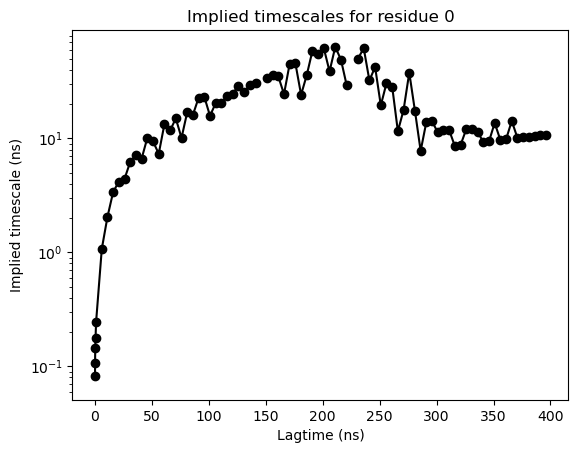

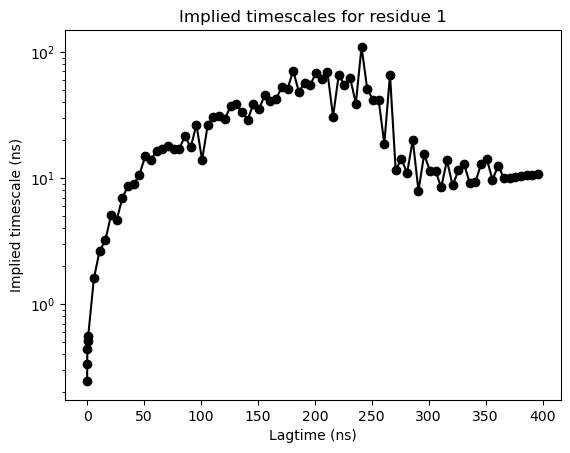

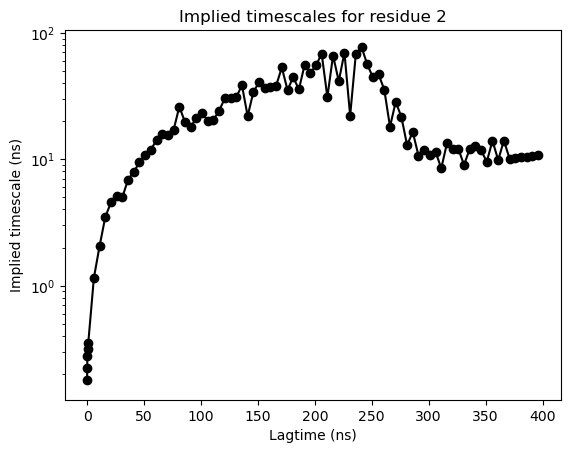

In [24]:
# Plotting
for i, residue in enumerate(residues):
    plt.figure()
    plt.plot(lagtimes_ns, t2_all_means[i] * dt_in_ns, 'ko-')
    plt.fill_between(lagtimes_ns, 
                     (t2_all_means[i] + t2_all_stds[i]) * dt_in_ns, 
                     (t2_all_means[i] - t2_all_stds[i]) * dt_in_ns, 
                     alpha=0.2)
    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Implied timescale (ns)')
    #plt.ylim(5, 1000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue}')
    plt.savefig(f"autocoorel_data/implied_timescale_res{residue}.png")
    plt.show()

In [26]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_stds, 
                      t2_all_means, t2_all_stds, lagtimes_ns])

# Save to a file
data_instance.save("autocoorel_data/residue_implied_timescale.pkl")
print(f" data save at autocoorel_data/residue_implied_timescale.pkl")

 data save at autocoorel_data/residue_implied_timescale.pkl


In [27]:
omega_loaded = Data.load("autocoorel_data/residue_implied_timescale.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_stds = omega_loaded[1]
t2_all_means = omega_loaded[2]
t2_all_stds = omega_loaded[3]
lagtimes_ns = omega_loaded[4]

pi_all_means.shape


(3, 84, 2)

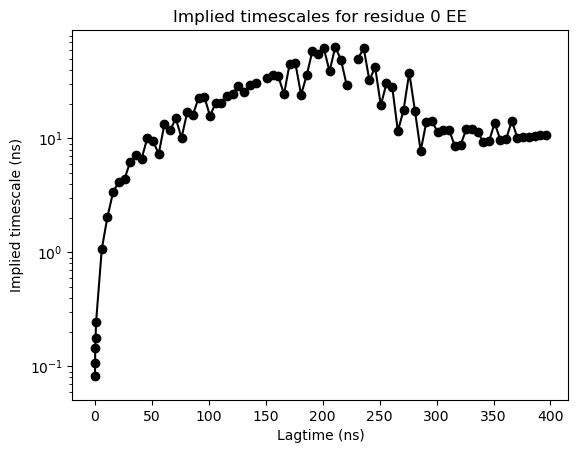

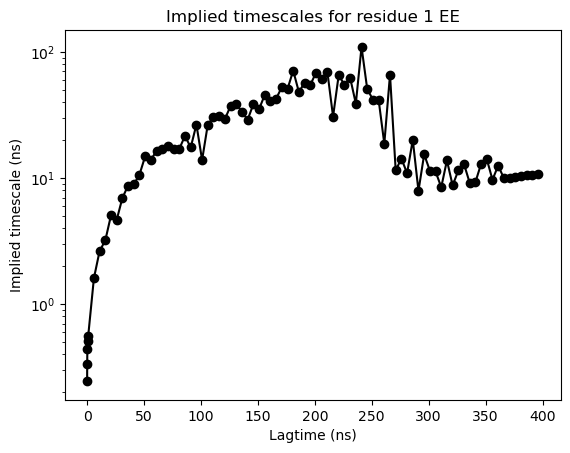

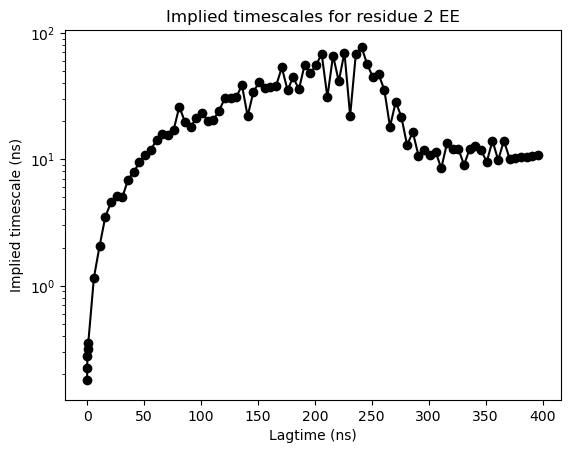

In [30]:
# Plotting
residues = [0, 1, 2]
dt_in_ns = 0.01 # 10 ps per step
for i, residue in enumerate(residues):
    plt.figure()
    plt.plot(lagtimes_ns, t2_all_means[i] * dt_in_ns, 'ko-')
    plt.fill_between(lagtimes_ns, 
                     (t2_all_means[i] + t2_all_stds[i]) * dt_in_ns, 
                     (t2_all_means[i] - t2_all_stds[i]) * dt_in_ns, 
                     alpha=0.2)
    plt.xlabel('Lagtime (ns)')
    plt.ylabel('Implied timescale (ns)')
    #plt.ylim(5, 1000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue} EE')
    #plt.show()
    plt.savefig(f"autocoorel_data/implied_timescale_res{residue}.png")

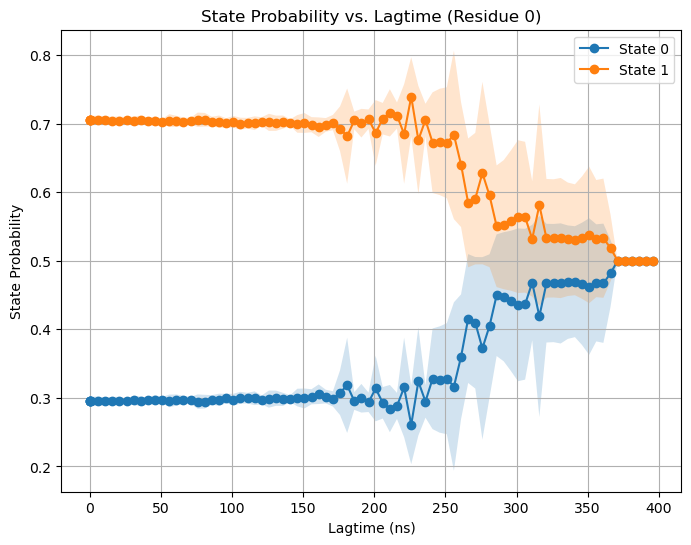

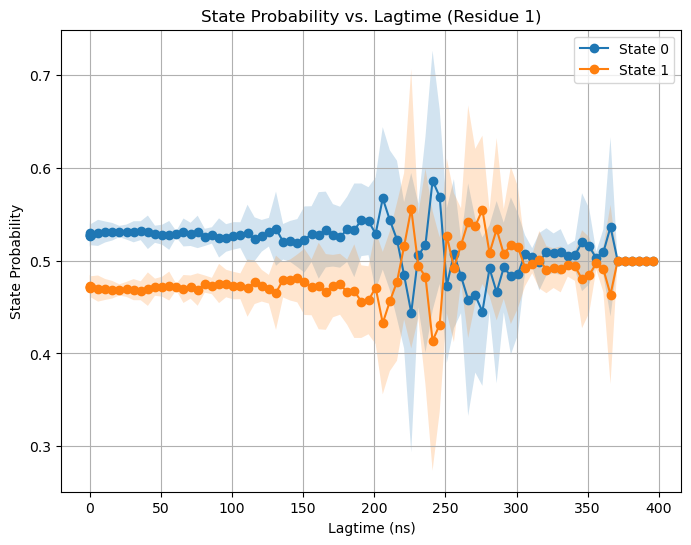

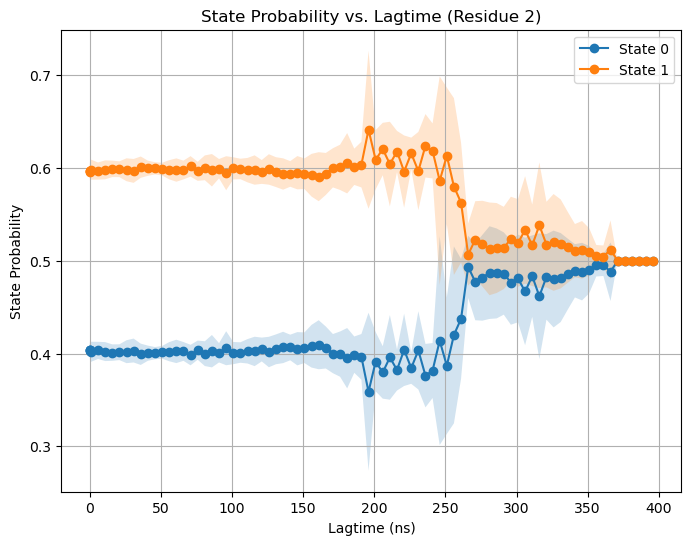

In [29]:
import matplotlib.pyplot as plt

residues = [0, 1, 2]
dt_in_ns = 0.01  # 10 ps per step
state_to_plot = [0, 1]

for res in residues:
    plt.figure(figsize=(8, 6))  # Create a new figure for each residue
    pi_means = pi_all_means[res]
    pi_stds = pi_all_stds[res] 

    for i, state in enumerate(state_to_plot):
        plt.plot(lagtimes_ns, pi_means[:, i], '-o', label=f'State {state}')
        
        # Add shaded region for standard deviation
        plt.fill_between(lagtimes_ns, 
                         pi_means[:, i] + pi_stds[:, i],  # Upper bound
                         pi_means[:, i] - pi_stds[:, i],  # Lower bound
                         alpha=0.2)
    
    plt.xlabel("Lagtime (ns)")
    plt.ylabel("State Probability")
    plt.title(f"State Probability vs. Lagtime (Residue {res})")
    plt.legend()
    plt.grid(True)
    
    # Fix: Use `res` instead of `residue`
    plt.savefig(f"autocoorel_data/stationary_population_res{res}.png", dpi=300)
    plt.show()
